# First, you need to import ImagesOriginales.zip and nt_toolbox.zip

# For the sake of simplicity we are gonna analyze only the first image (even thought I made several test with other images)

#Here we have all the functions that should be fixed


In [1]:
import zipfile
import os
with zipfile.ZipFile("nt_toolbox.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())
from __future__ import division
from nt_toolbox.nt_toolbox.general import *
from nt_toolbox.nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import skimage
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import operator
import pandas as pd
import time
from logging import exception


with zipfile.ZipFile("ImagesOriginales.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())

def generateNoise(img, mode,seed,var,clip = False):
    ###
    # img : input image
    # mode : gaussian , poisson, speckle
    # seed : seed for the random generator
    # clip : True or False (clip the output in the range -1 , 1)
    # var : (variance for Gaussian and speckle mode)
    ###

    if mode == 'gaussian' or mode == 'speckle':
        gimg = skimage.util.random_noise(img, mode=mode,seed=seed,clip=clip,var=var)
        return gimg
    if mode == 'poisson':
      np.random.seed(seed)
      gimg = np.random.poisson(img * 100 + 155)
      gimg = gimg / 255
      return gimg

def TV_norm(gradX):
  ###
  # gradX : input tensor of shape (m,n,2)
  ###
  sum = 0
  (m,n,k) = np.shape(gradX)
  if(k != 2):
    print("The shape of GradX is not what was expected")
    raise exception
  sum = (np.sqrt(gradX[:,:,0]**2 + gradX[:,:,1]**2)).sum().sum()
  return sum

def zeroOneScaling(img):
  ###
  # img : input image
  ###
  if np.max(img) > 1 or np.min(img) < 0:
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
  return img
def cappingZeroOne(img):
  img = np.array(img)
  img = np.clip(img, 0, 1)
  return img

def plotResults(img , y ,xk , cost, err, SSIMerr, SSIMimprovement, lmbda):
    lmbda = str(lmbda)

    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(1, 3, 2)
    plt.imshow(y, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(1, 3, 3)
    plt.imshow(xk, cmap='gray')
    plt.title('Reconstruction for lambda = ' + lmbda)
    plt.show()

    # plot how the cost function decreases and how the iterates converge
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(1, 2, 2)
    plt.plot(err)
    plt.xlabel('$k$')
    plt.ylabel("$|x_k - img|_2$")
    plt.title('L2 norm between GT and xk')


    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(SSIMerr)
    plt.xlabel('$k$')
    plt.ylabel("$SSIM$")
    plt.title('SSIM between GT and xk')
    plt.subplot(1, 2, 2)
    plt.plot(SSIMimprovement)
    plt.xlabel('$k')
    plt.ylabel('$SSIM$')
    plt.title('SSIM between $x_k$ and $x_{k+1}$')
    plt.show()

c:\Users\Claudio\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Claudio\anaconda3\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [16]:
def GradientDescent(x0, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-5):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  (n1,n2) = np.shape(y)
  xkSeq = np.zeros(shape = (maxiter,n1,n2))
  epsilon = 0.4*1e-2
  tau = 1.9 / (1 + lmbda * 8 / epsilon)
  for k in range(0,maxiter):

     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     xk = xk - tau*(e + lmbda*G)
     xk = cappingZeroOne(xk)

     xkSeq[k] = xk
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norm
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 1)

     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 10 * stopping_threshold:
        print(f"I got stopped at iteration {k} because of Cost function")
        break
      if np.linalg.norm(xkSeq[k] - xkSeq[k-1],1) / np.linalg.norm(xkSeq[k],1) < stopping_threshold:
        print(f"I got stopped at iteration {k} because of Sequence norm")
        break
      """
      elif (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
        cost[k:maxiter] = cost[k]
        err[k:maxiter] = err[k]
        SSIMerr[k:maxiter] = SSIMerr[k]
        print(f"I got stopped at iteration {k} because of SSIM")
        break
      """


  return xk, lmbda, cost, err, SSIMerr, xkSeq, k


def SSIMGradientDescent(x0, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-5):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  xkSeq = []
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  tau = 1.9 / (1 + lmbda * 8 / epsilon)
  for k in range(0,maxiter):

     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     xk = xk - tau*(e + lmbda*G)
     xk = cappingZeroOne(xk)

     xkSeq.append(xk)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norm
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 1)

     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 10 * stopping_threshold:
        cost[k:maxiter] = cost[k]
        err[k:maxiter] = err[k]
        SSIMerr[k:maxiter] = SSIMerr[k]
        print(f"I got stopped at iteration {k} because of Cost function")
        break

      elif (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
        cost[k:maxiter] = cost[k]
        err[k:maxiter] = err[k]
        SSIMerr[k:maxiter] = SSIMerr[k]
        print(f"I got stopped at iteration {k} because of SSIM")
        break



  return xk, lmbda, cost, err, SSIMerr, xkSeq

In [27]:
def runScript(img,lmbda, early_stopping, SSIMstop, maxiter = 400, mode = 'gaussian'):
  y = generateNoise(img,mode = mode,seed = 43,clip = False,var = 0.02)

  for lmbdak in lmbda:
    xk = y
    if SSIMstop == True:
      xk, lmbda, cost, err, SSIMerr, xkSeq = SSIMGradientDescent(xk, lmbdak, maxiter, y, img, early_stopping, stopping_threshold = 10e-5)
    else:
      xk, lmbda, cost, err, SSIMerr, xkSeq, iter = GradientDescent(xk, lmbdak, maxiter, y, img, early_stopping, stopping_threshold = 10e-5)
    SSIMimprovement = []
    cost = cost[:iter+1]
    err = err[:iter+1]
    SSIMerr = SSIMerr[:iter+1]
    for i in range(0,iter):
      SSIMimprovement.append(skimage.metrics.structural_similarity(xkSeq[i],xkSeq[i+1],data_range=1))
    plotResults(img,y,xk,cost, err, SSIMerr, SSIMimprovement, lmbdak)

Some random testing of the code

I got stopped at iteration 327 because of Cost function


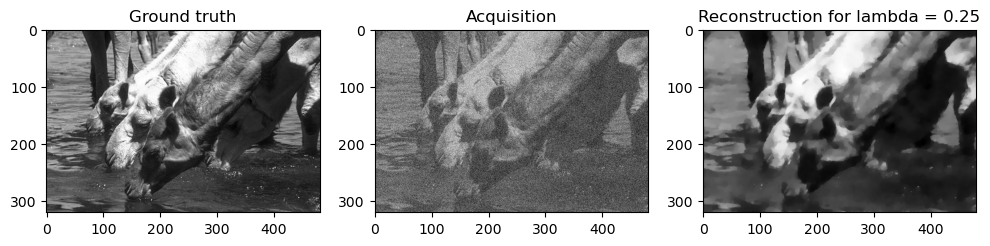

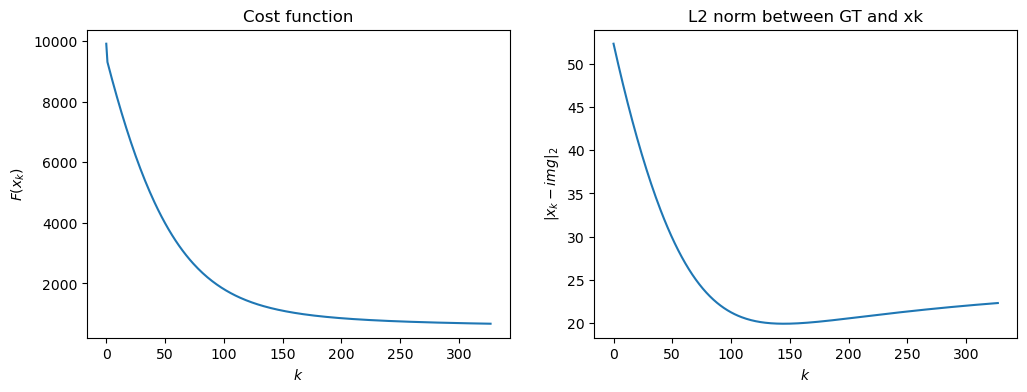

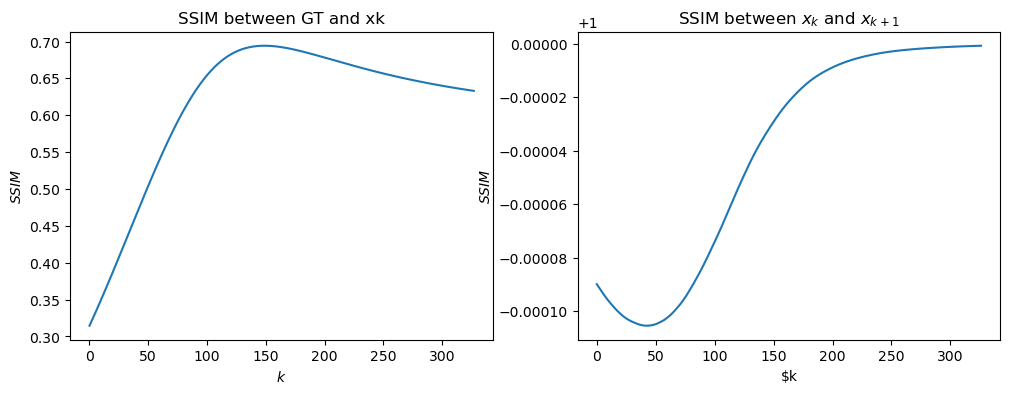

In [28]:
for j in range(1,2):
  filename = "ImagesOriginales/%s.jpg" %j
  img = np.array(plt.imread(filename)/255, dtype="float64")
  lmbda = [0.25]
  runScript(img,lmbda, SSIMstop = False, early_stopping = True)

## Tested with Gaussian noise and images clipped between 0 and 1 during preprocessing and for each iteration of gradient discent.
## I have plotted the graphs for different images from the dataset without early stopping and with max_iterations set to 400.

## For each image, I also plotted the graph of SSIM(x_k, x_{k+1})
## We hoped that the maximum SSIM would occur at the same iteration number as the minimum SSIM(x_k, x_{k+1}), but this is not the case as it has shown.

Considerations:
Some images reached the peak in the SSIM values with more iteration, meaning that we need higher values of lambda for reaching a good peak of SSIM
These images are usually the image with fewer details like the two birds!

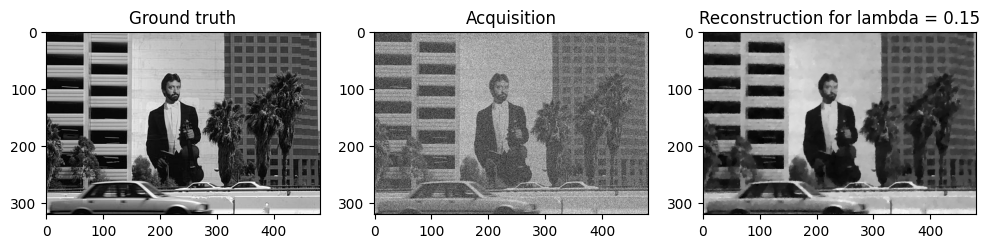

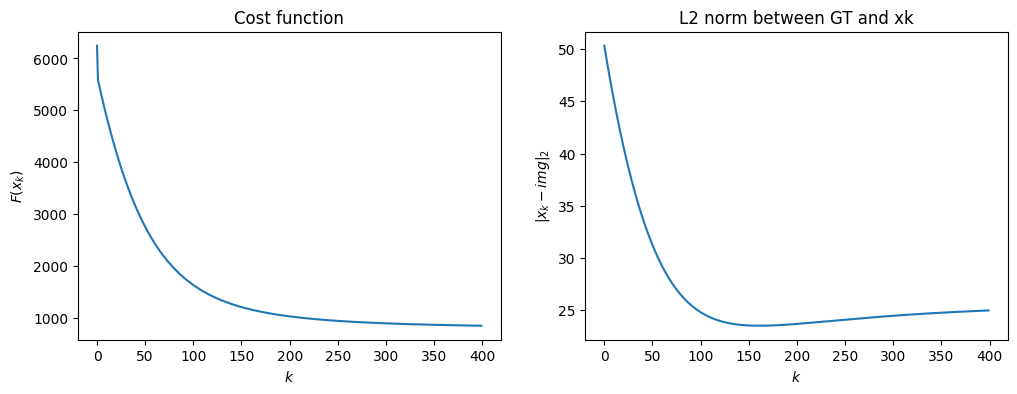

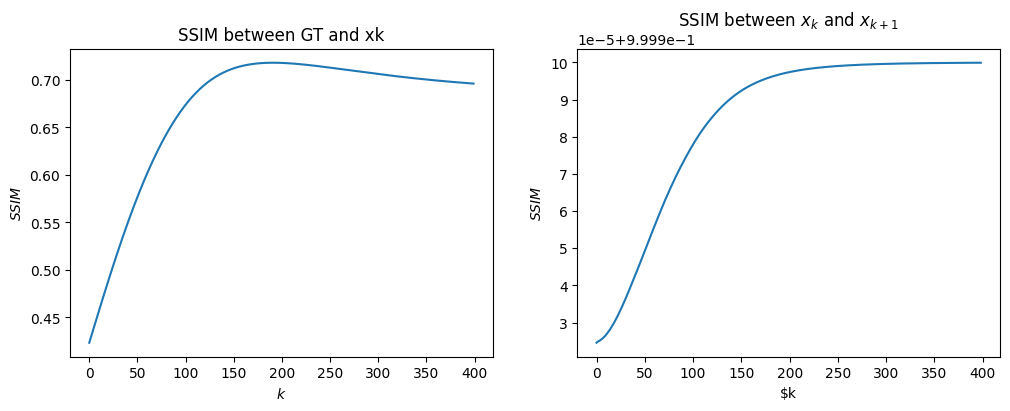

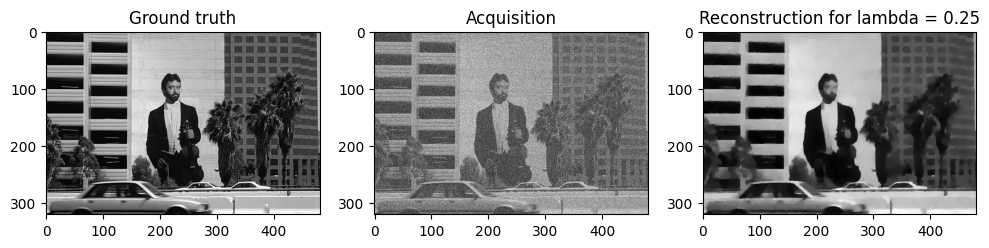

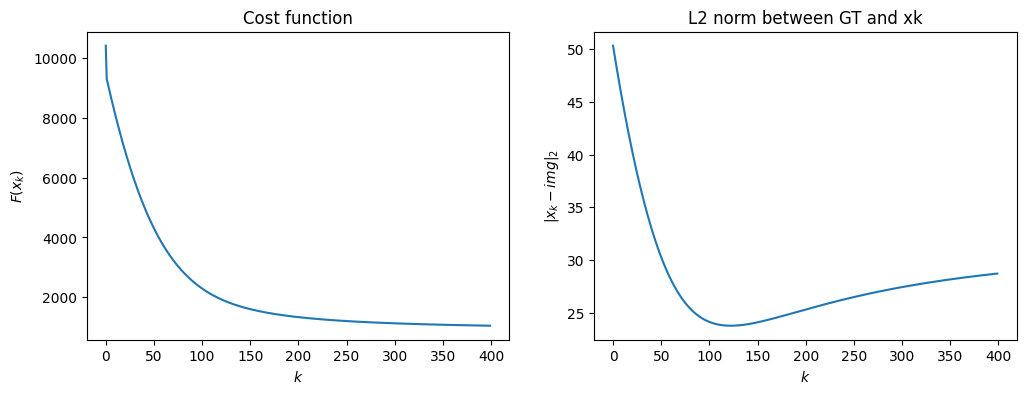

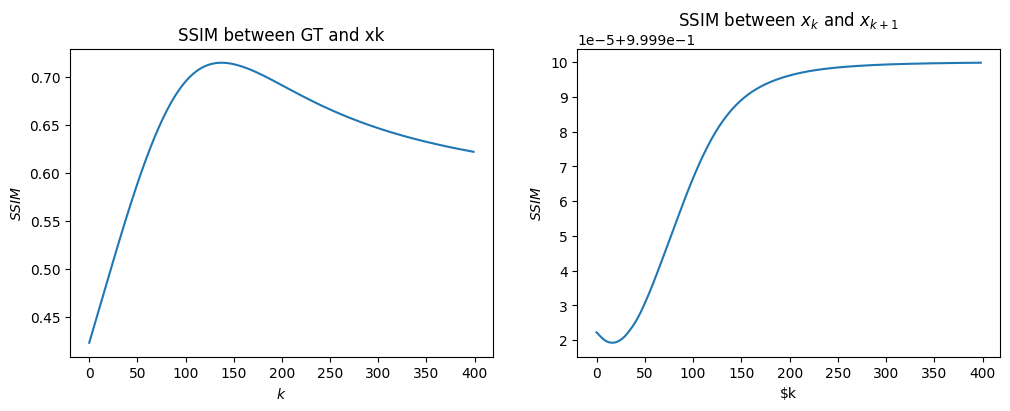

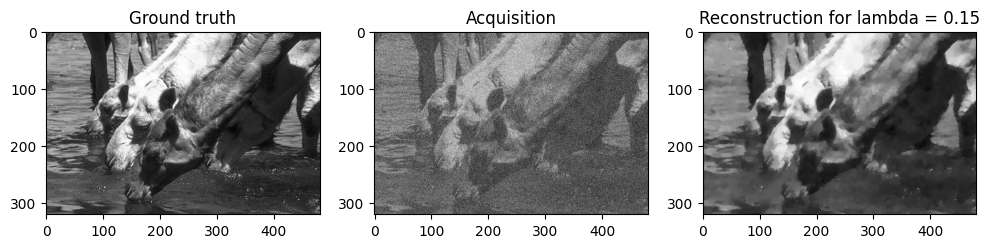

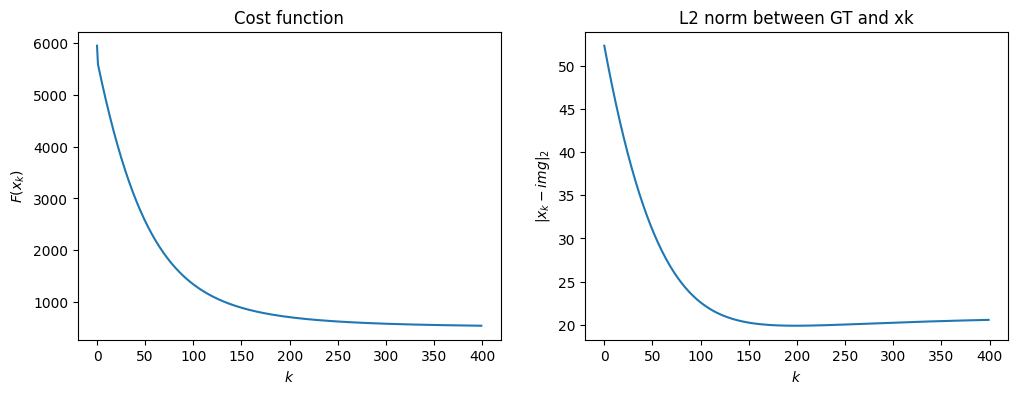

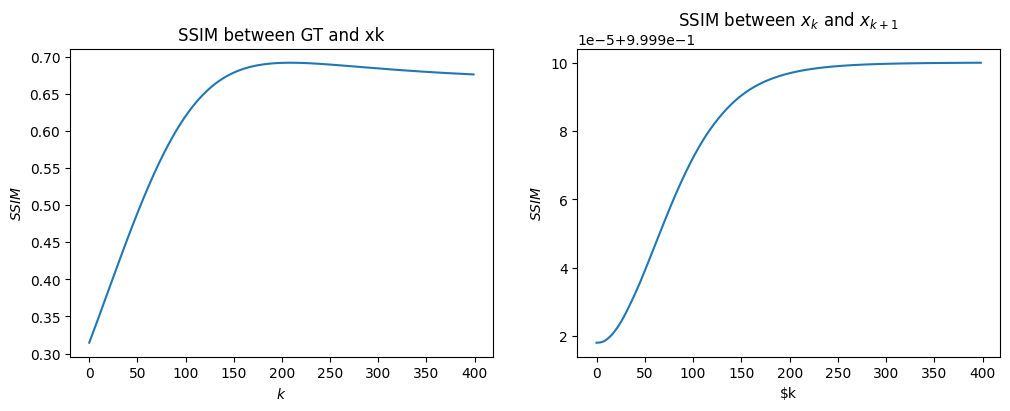

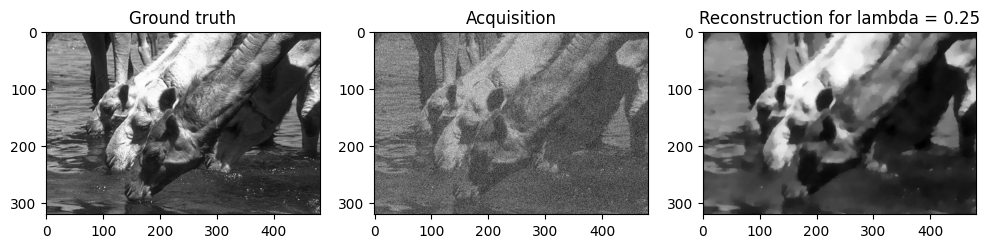

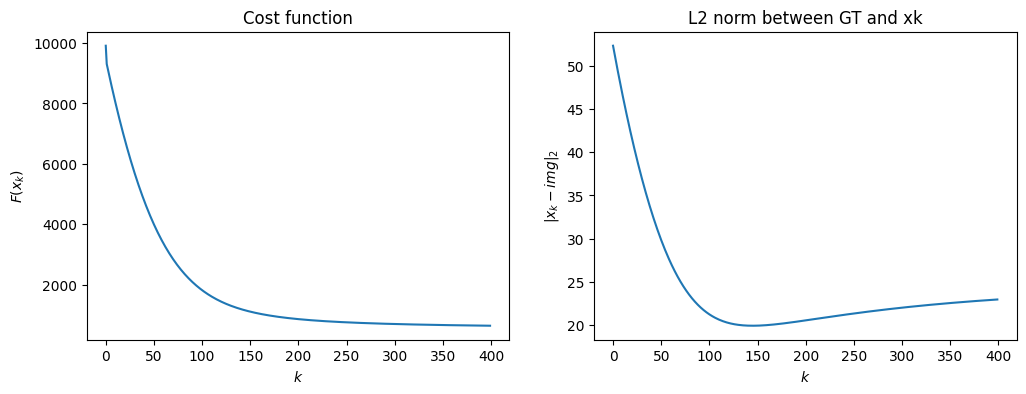

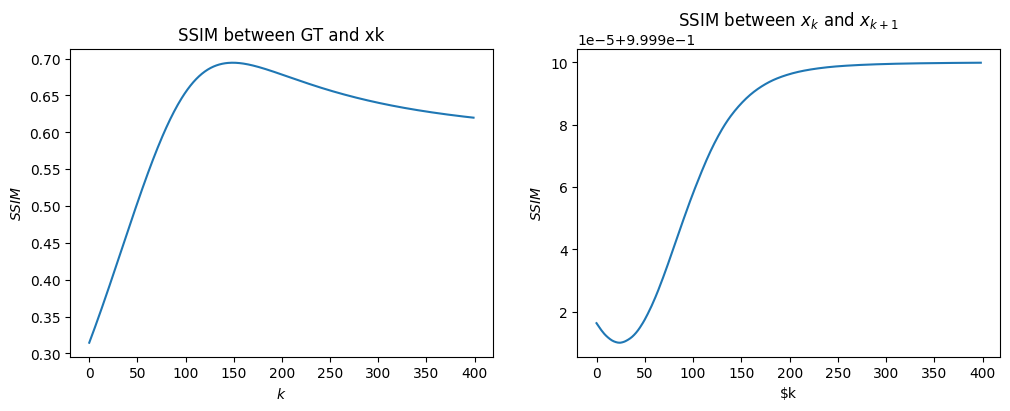

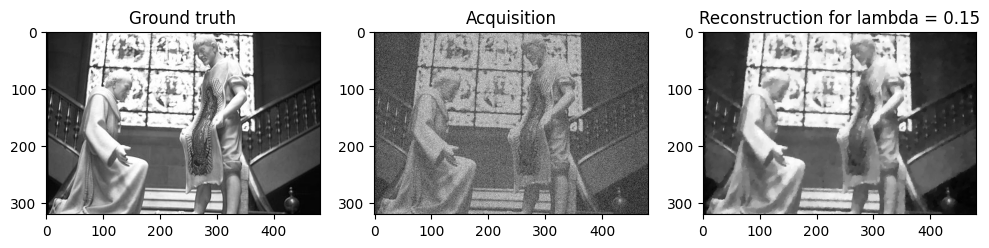

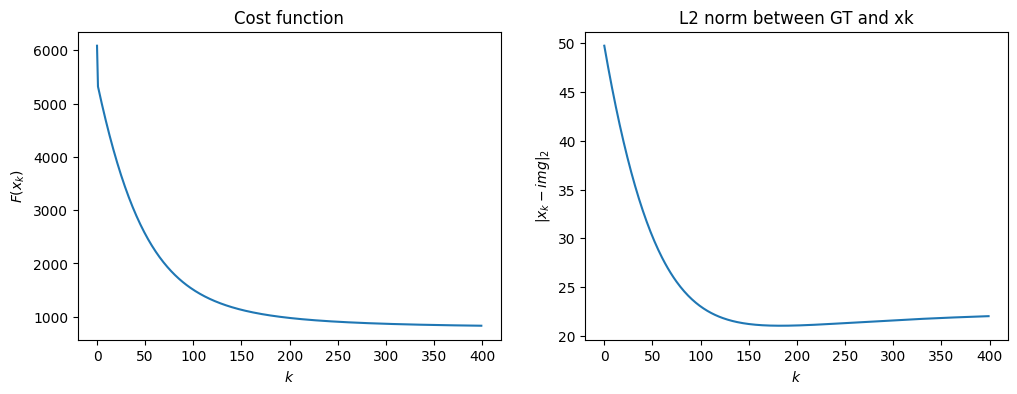

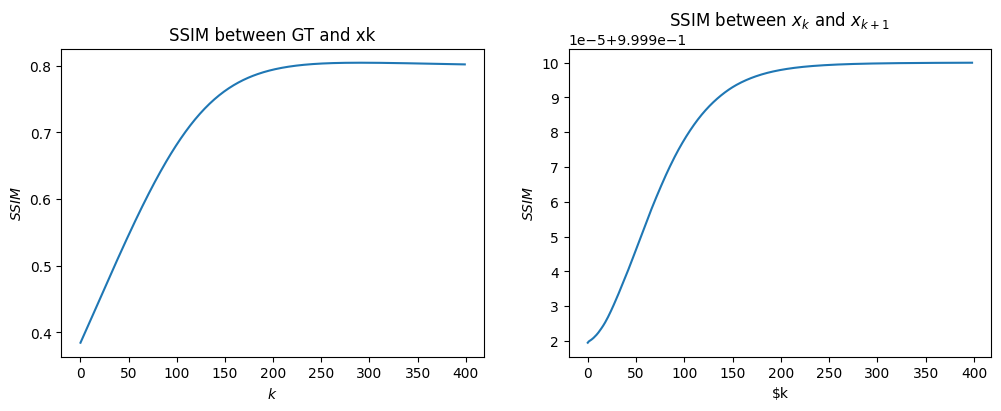

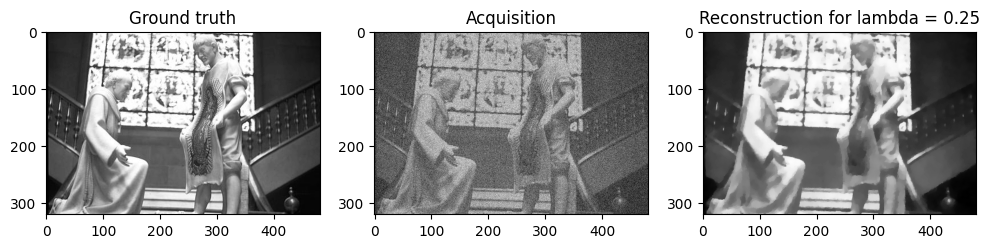

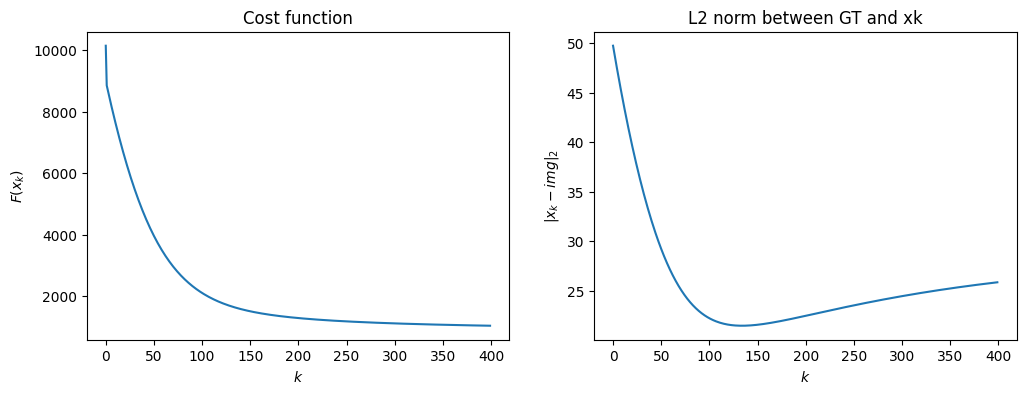

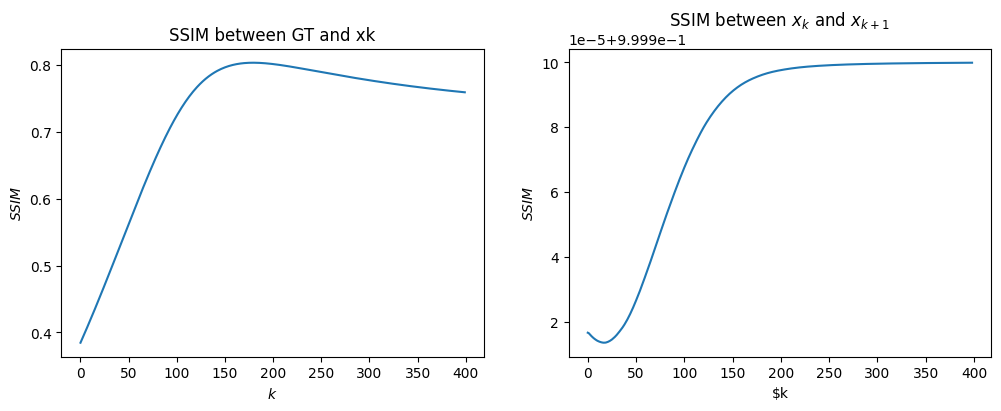

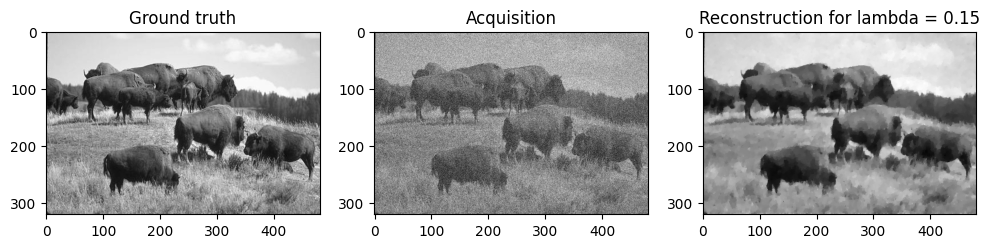

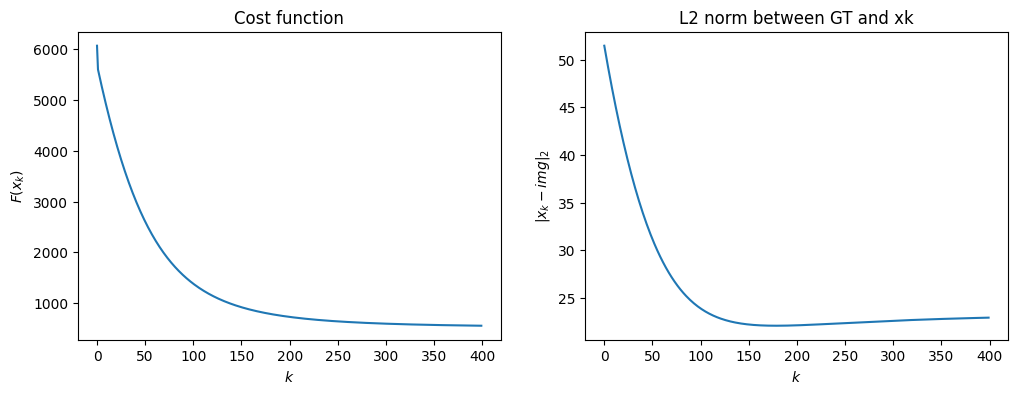

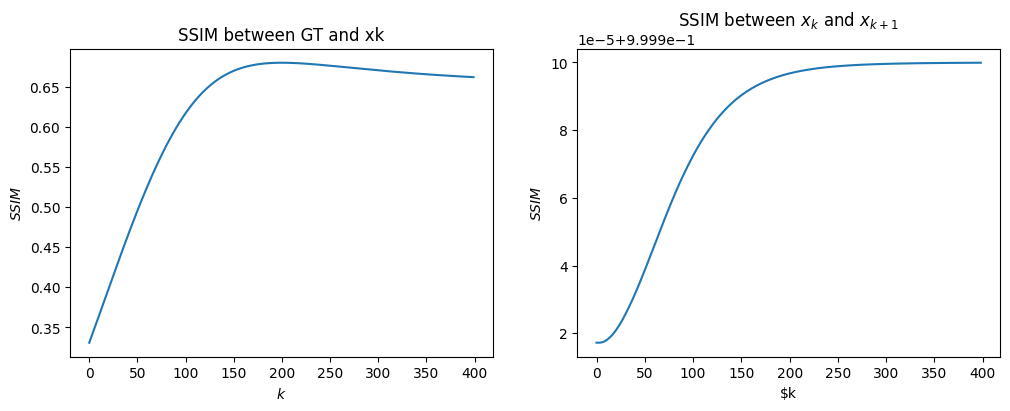

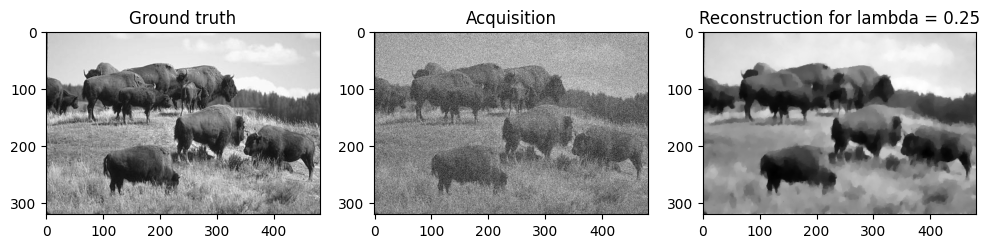

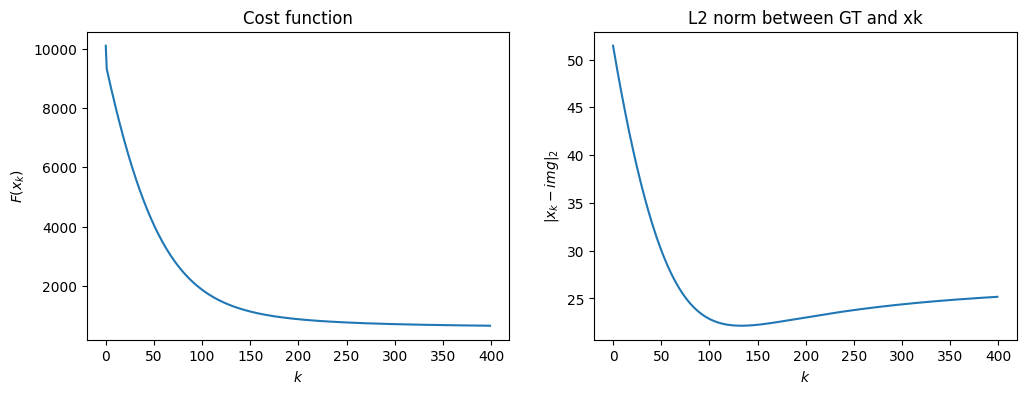

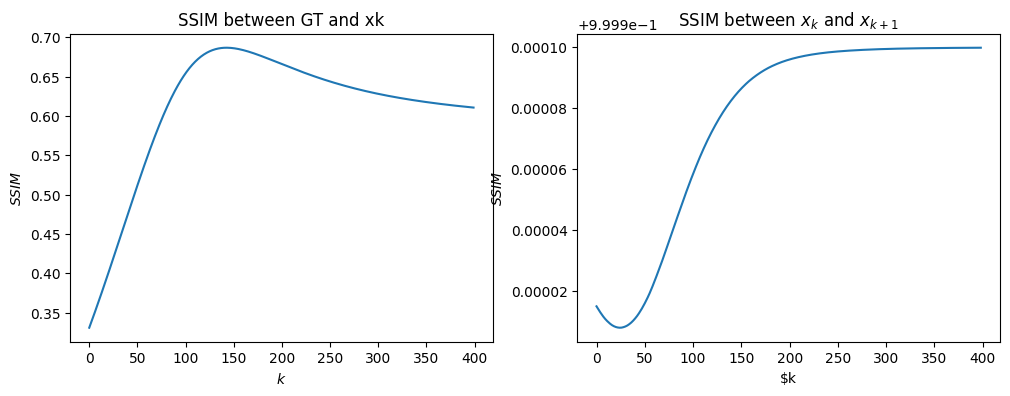

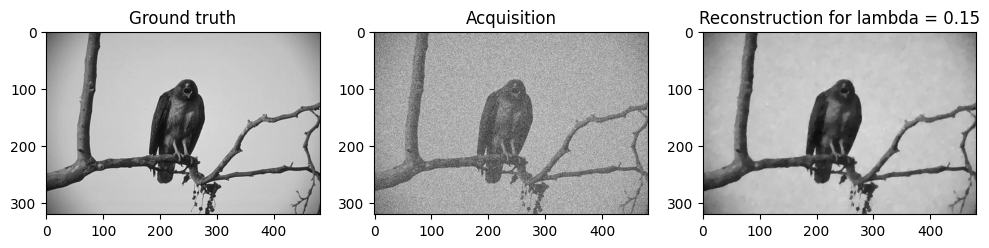

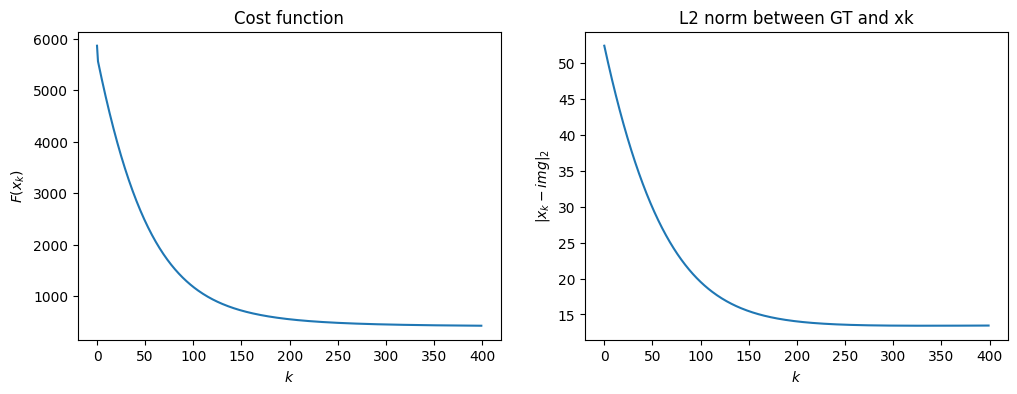

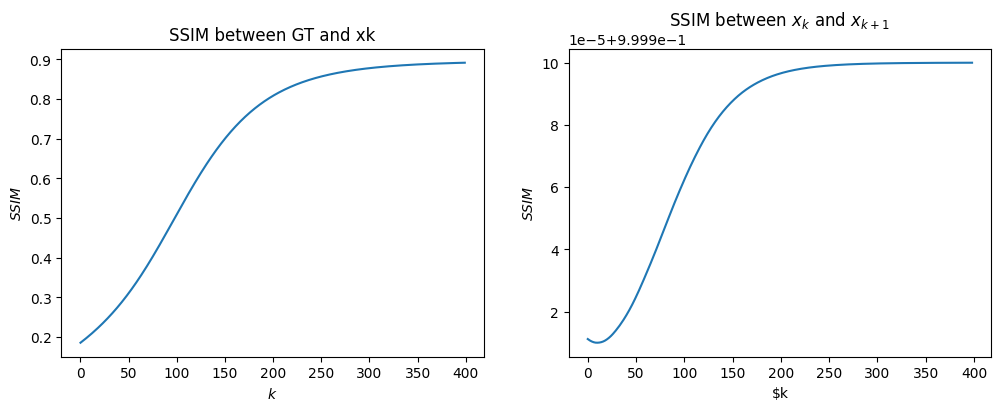

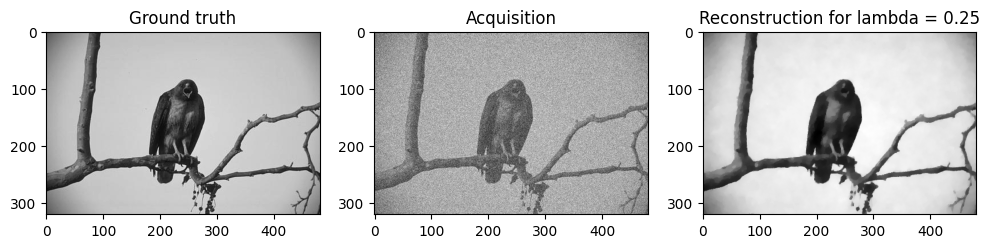

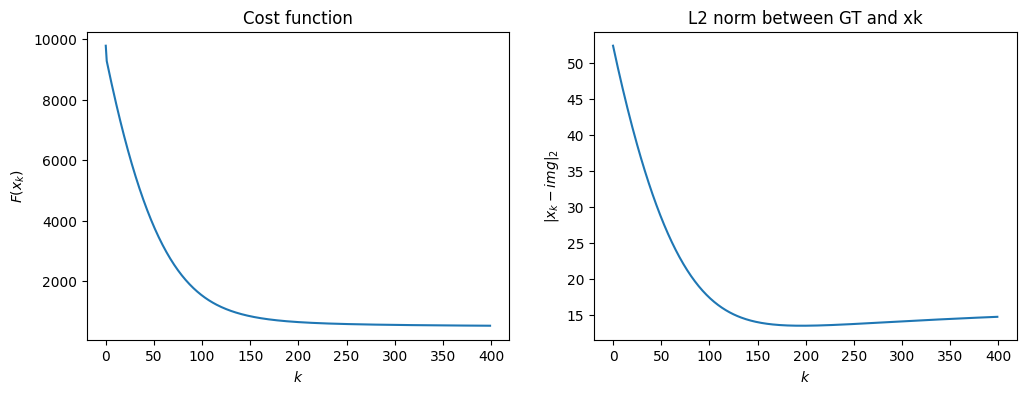

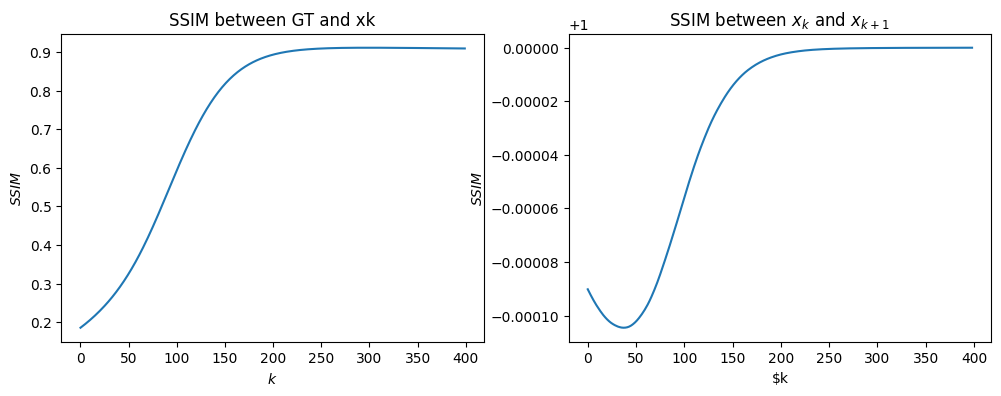

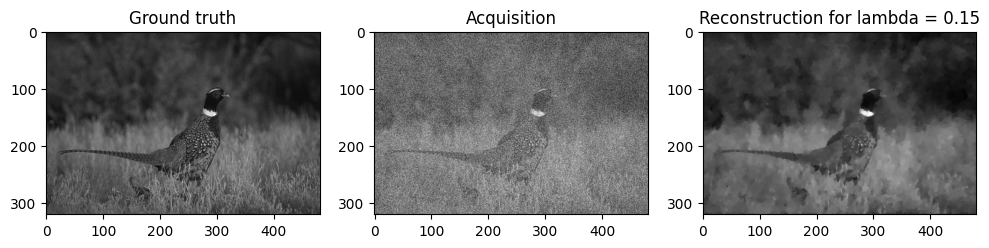

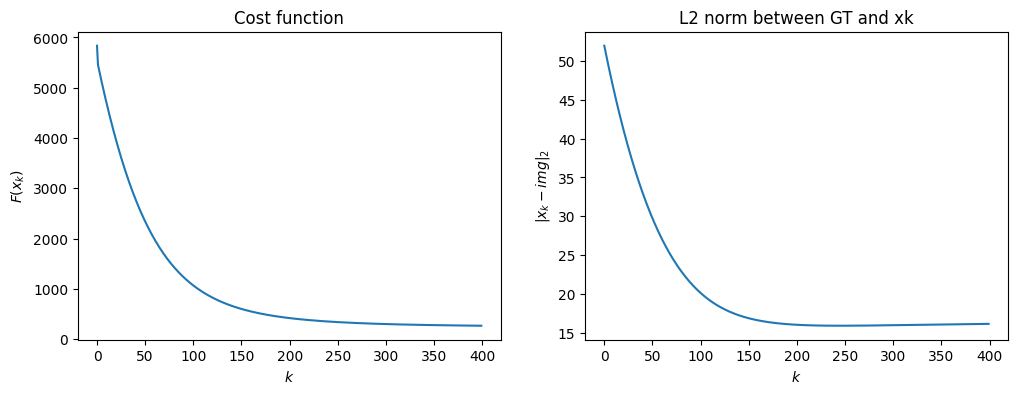

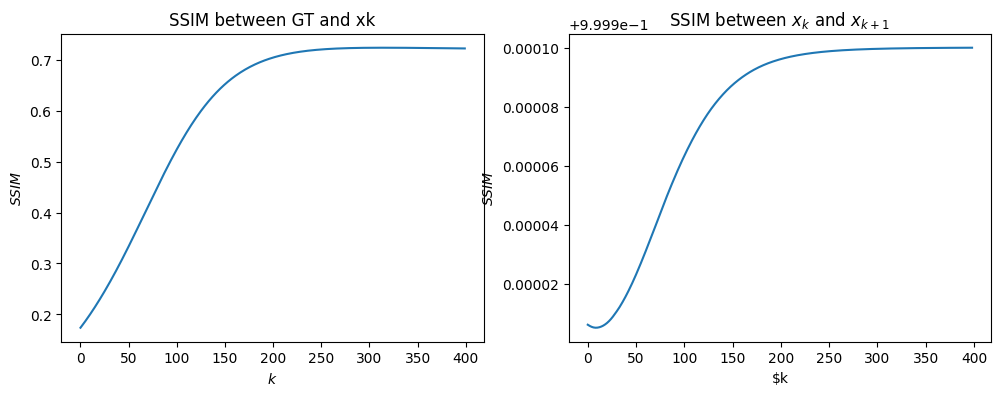

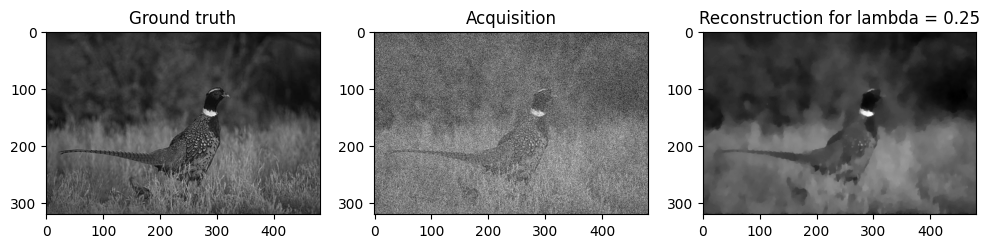

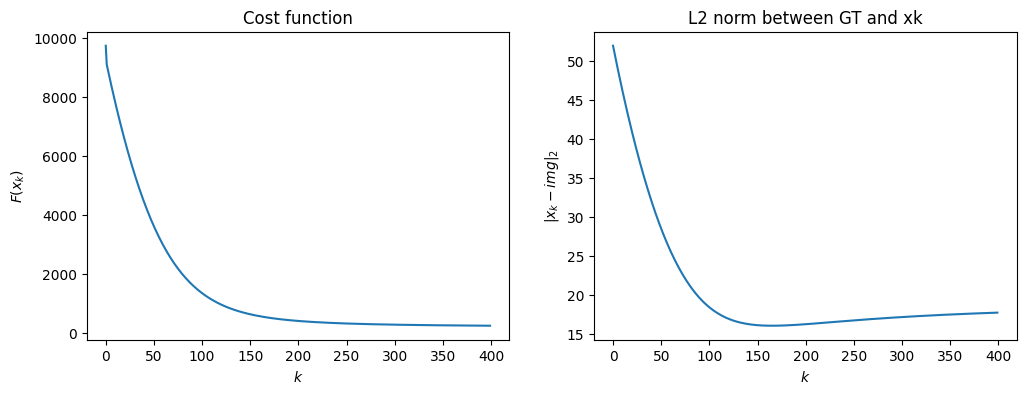

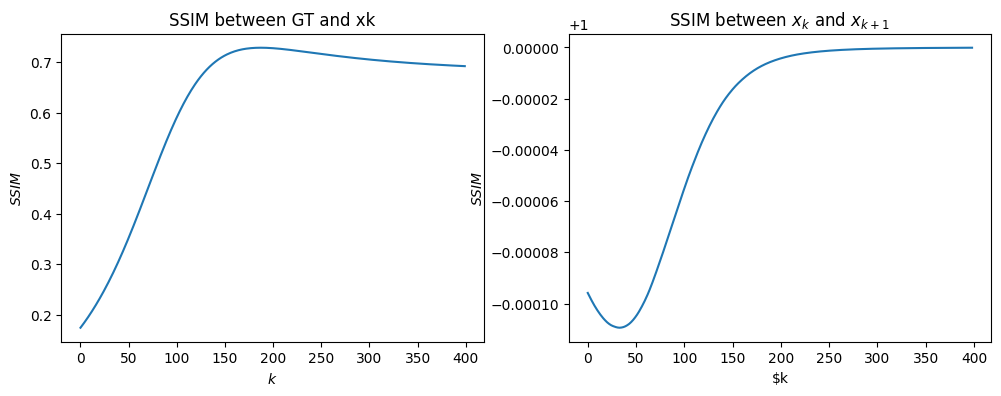

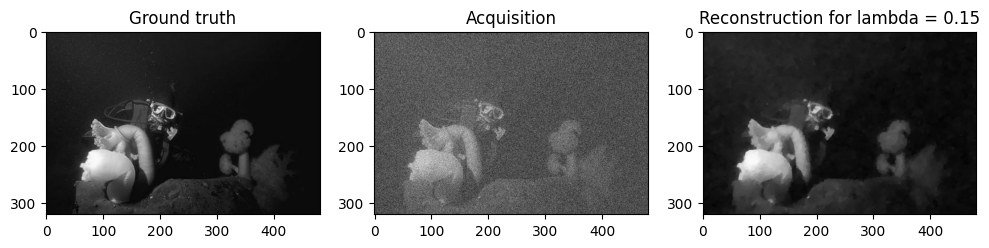

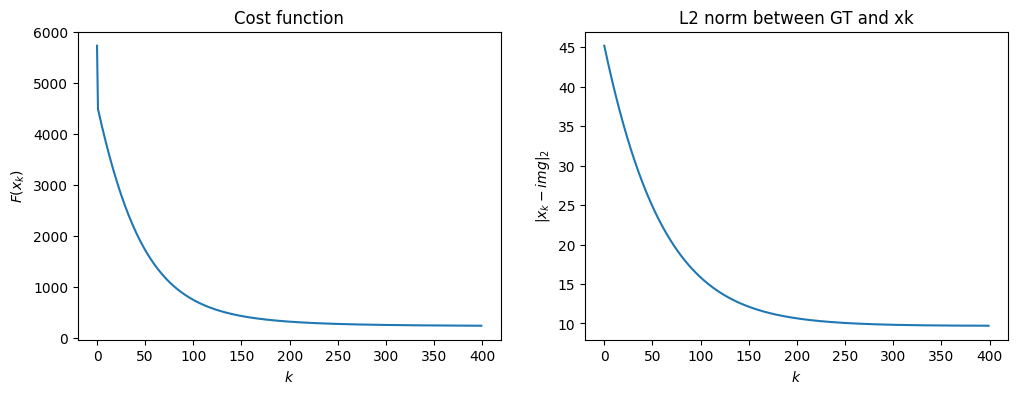

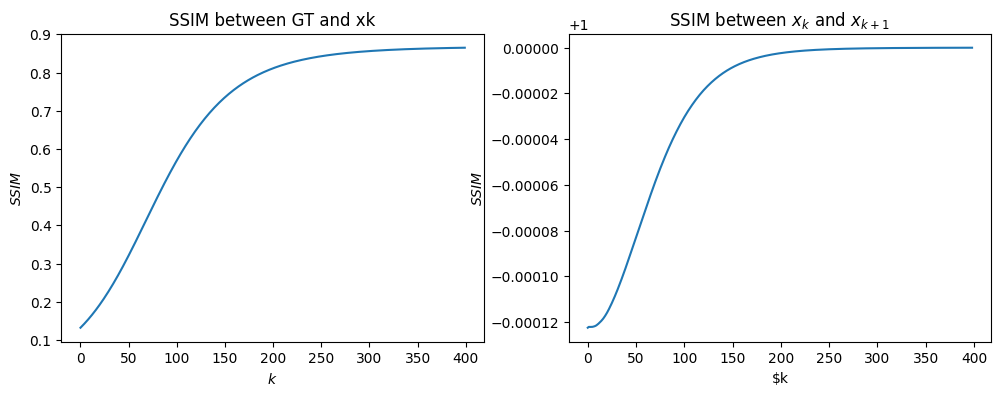

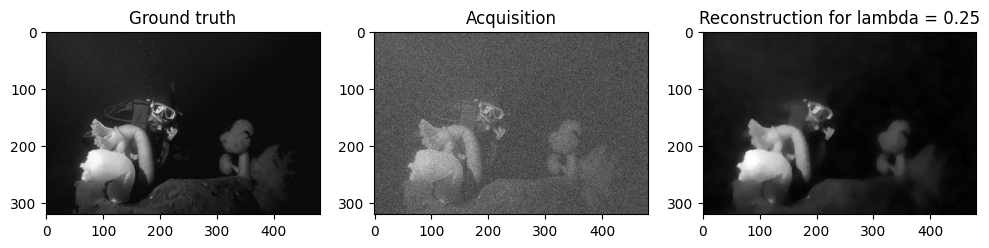

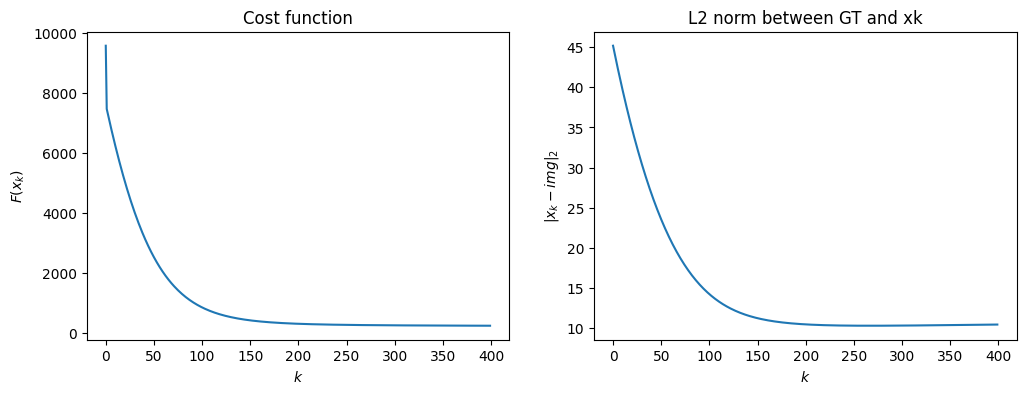

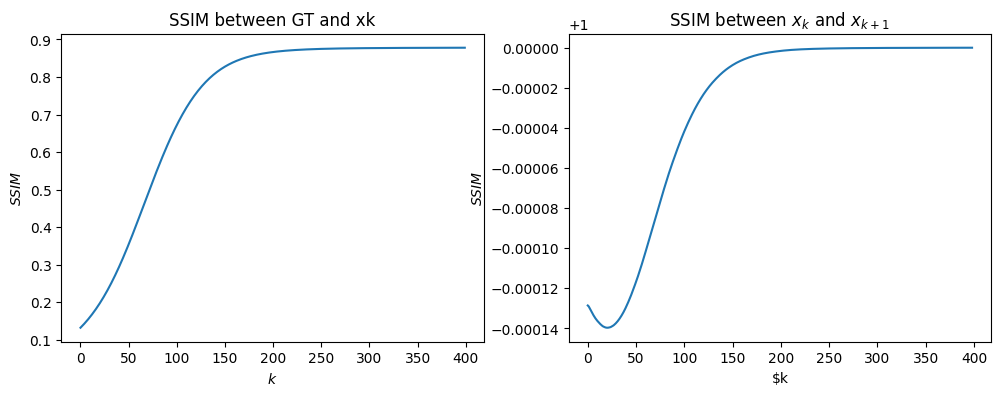

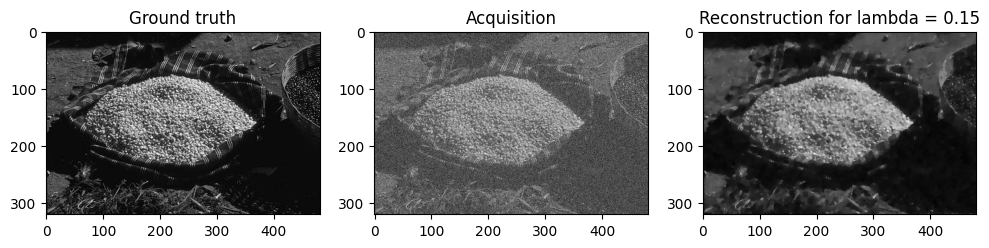

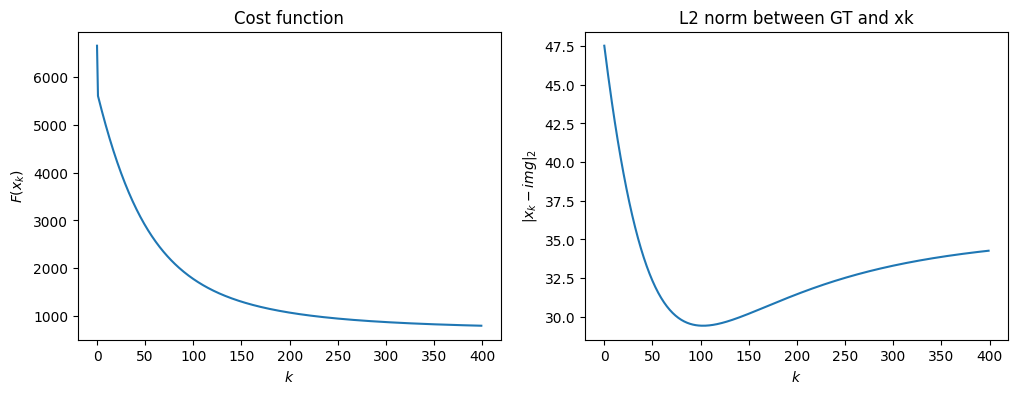

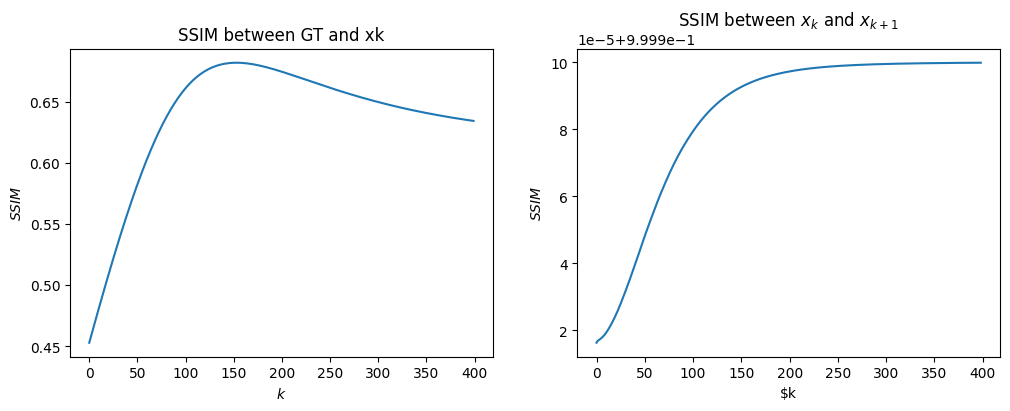

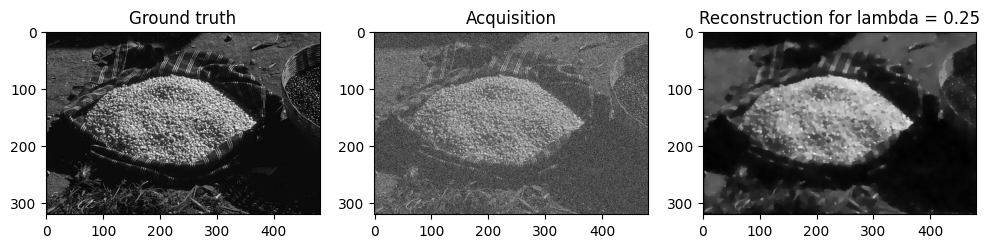

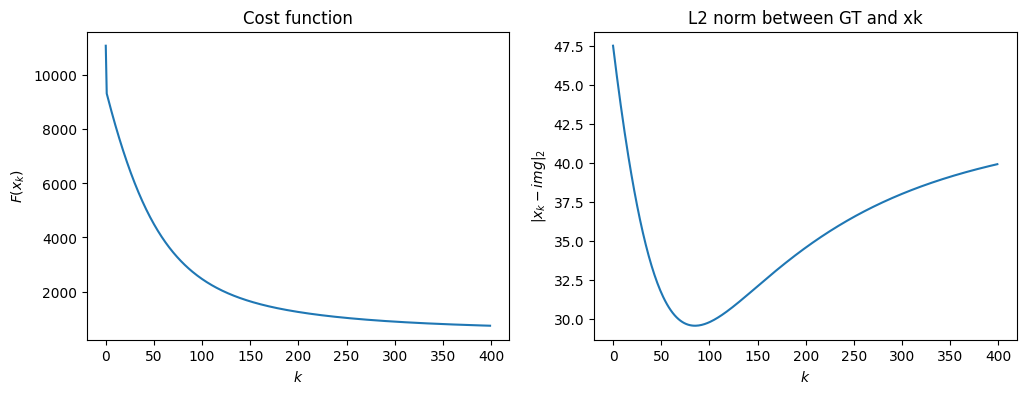

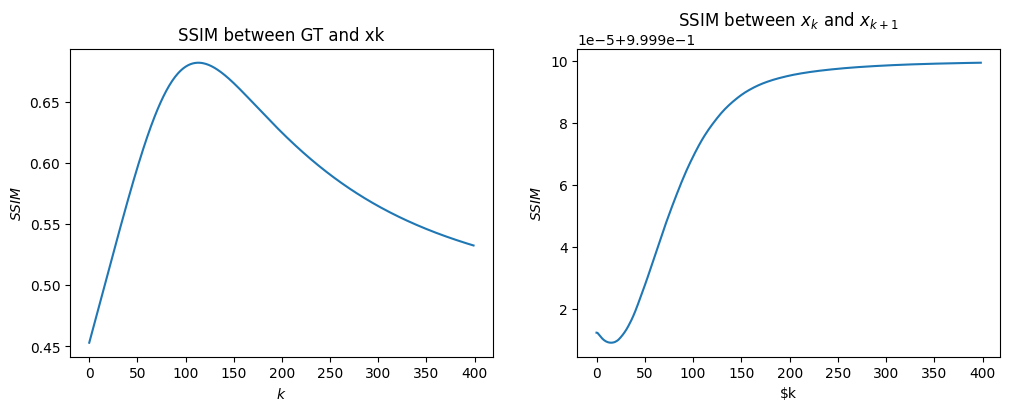

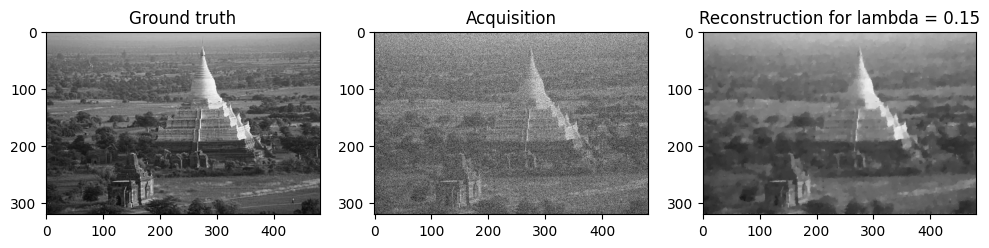

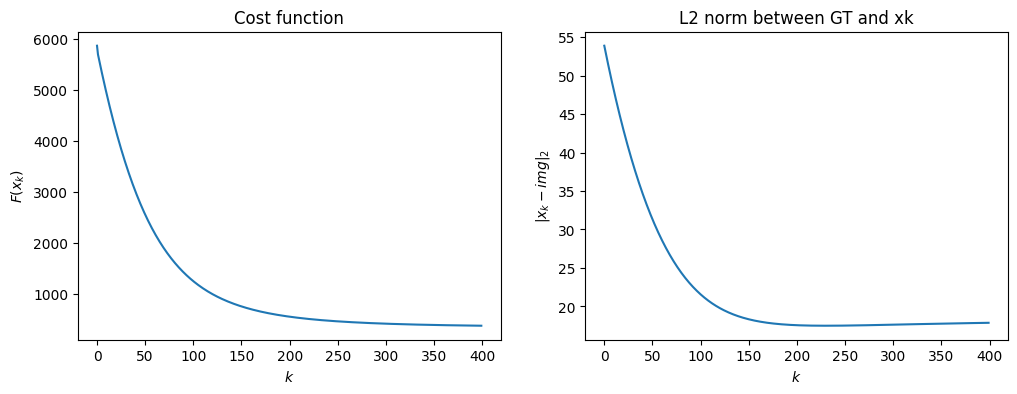

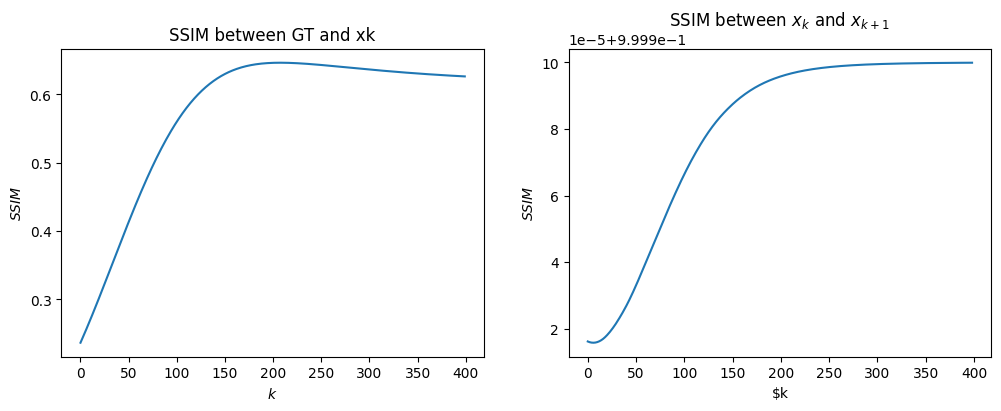

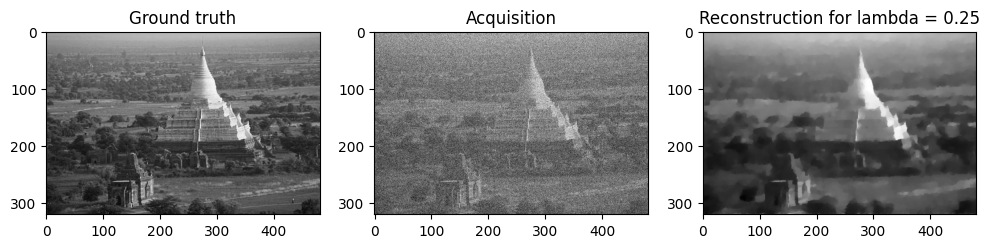

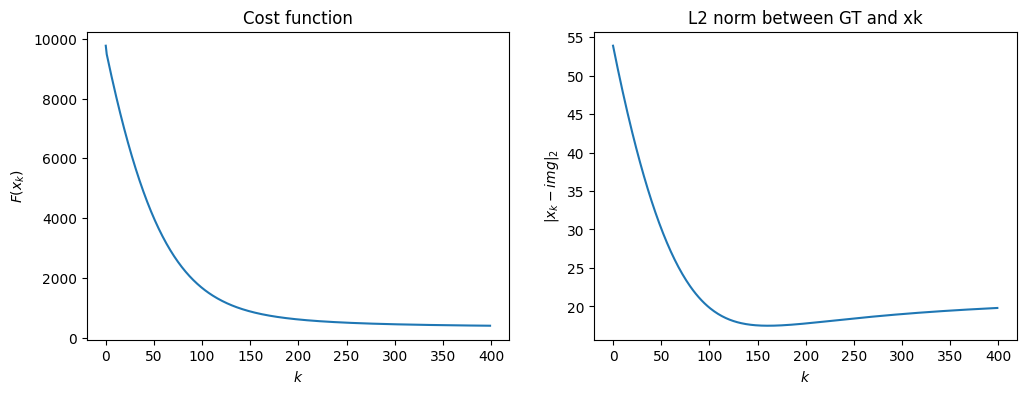

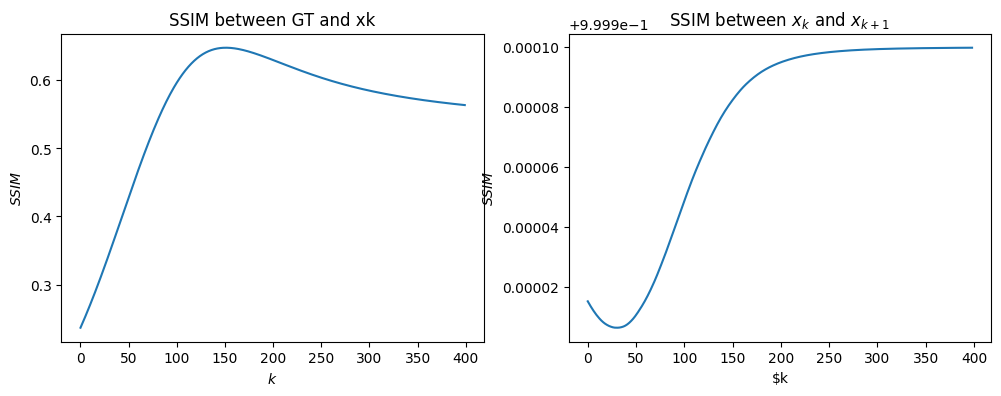

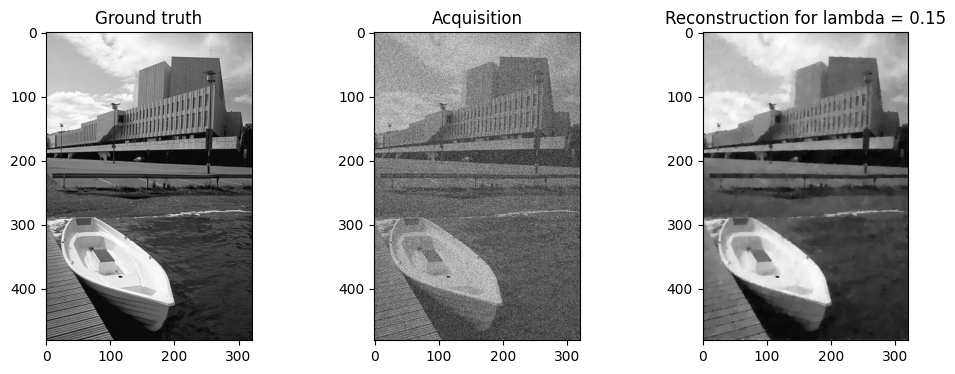

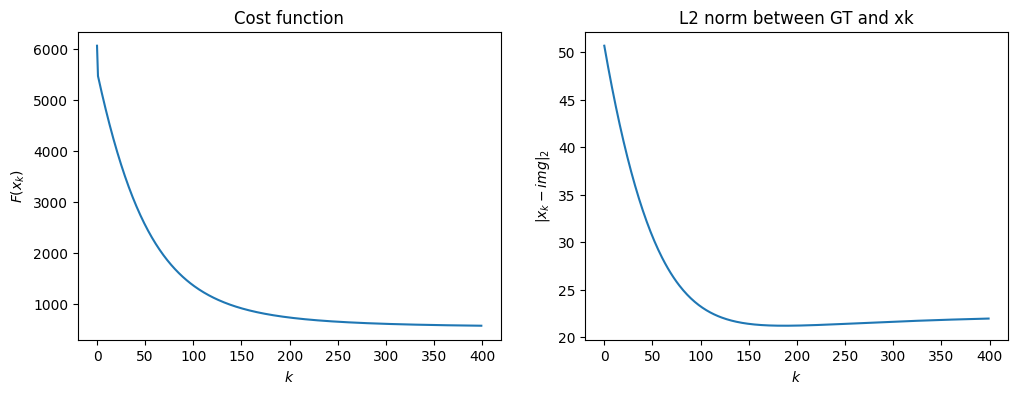

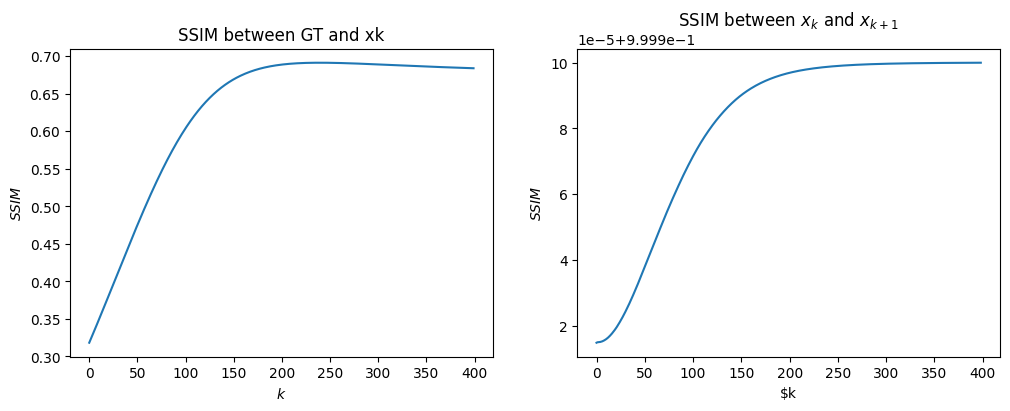

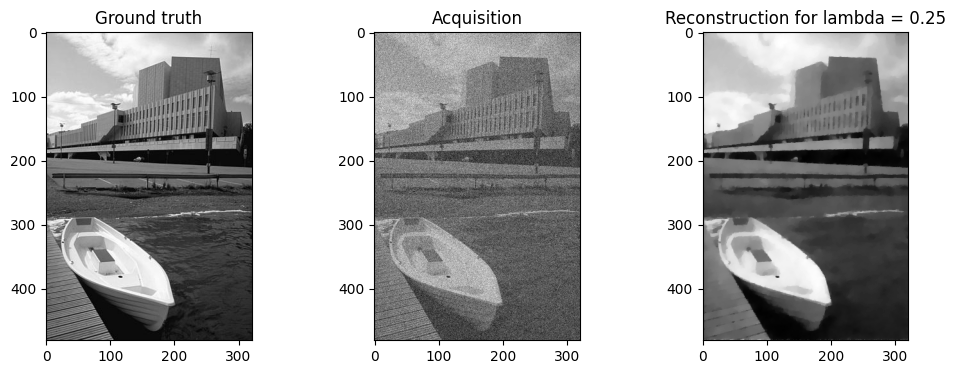

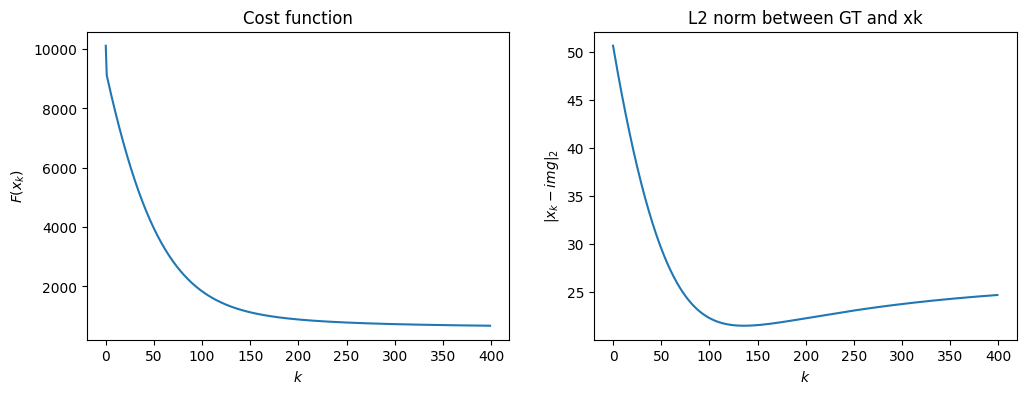

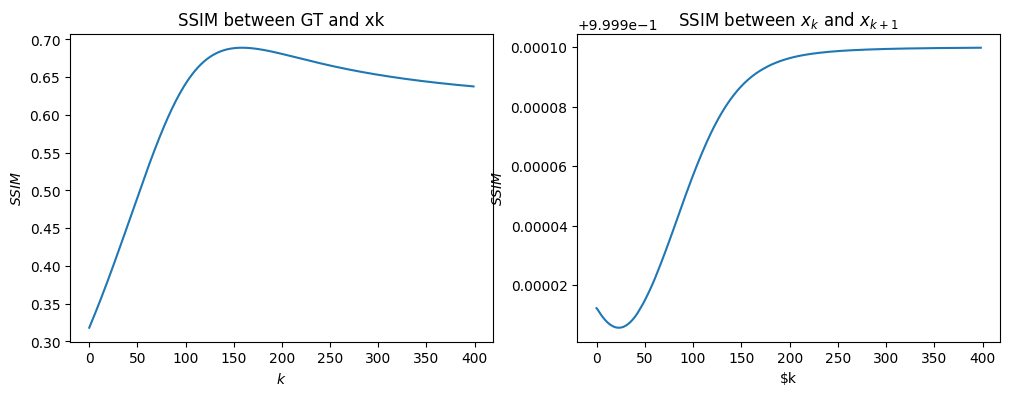

In [43]:
maxiter = 400


for j in range(0,10):
  lmbda = [0.15,0.25]
  filename = "ImagesOriginales/%s.jpg" %j
  img = np.array(plt.imread(filename)/255, dtype="float64")
  y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)

  for lmbdak in lmbda:
    xk = y
    xk, lmbda, cost, err, SSIMerr, xkSeq = GradientDescent(xk, lmbdak, maxiter, y, img, early_stopping = False, stopping_threshold = 10e-6)
    SSIMimprovement = []
    for i in range(0,400-1):
      SSIMimprovement.append(skimage.metrics.structural_similarity(xkSeq[i],xkSeq[i+1]))
    plotResults(img,y,xk,cost, err, SSIMerr, SSIMimprovement, lmbdak)


In [13]:
def runBruteScript(img,lmbda, stopValue, early_stopping, SSIMstop, maxiter = 400, mode = 'gaussian'):
  start = time.time()
  y = generateNoise(img,mode = mode,seed = 43,clip = False,var = 0.02)
  SSIMval = []
  s = {}

  for lmbdak in lmbda:
    if(10*lmbdak % 1 == 0):
      print(f"Iteration {10* lmbdak / 0.1} / {10 * (stopValue - 0.01) / 0.1}")

    xk = y
    if SSIMstop == True:
      xk, lmbda, cost, err, SSIMerr, xkSeq = SSIMGradientDescent(xk, lmbdak, maxiter, y, img, early_stopping, stopping_threshold = 10e-5)
    if SSIMstop == False:
      xk, lmbda, cost, err, SSIMerr, xkSeq = GradientDescent(xk, lmbdak, maxiter, y, img, early_stopping, stopping_threshold = 10e-5)
    s[lmbdak] = SSIMerr[maxiter-1]
    SSIMval.append(SSIMerr[maxiter-1])
  lmbda = max(s.items(), key=operator.itemgetter(1))[0]
  end = time.time()
  print(f"computational time required {end - start} s and the optima lambda is {lmbda} with SSIM value of {s[lmbda]}")
  plt.figure(figsize = (8,6))
  plt.plot(np.arange(0,stopValue,0.01),SSIMval)
  plt.xlabel('Lambda Values')
  plt.ylabel('SSIM between xk and GT')
  plt.show()

## Performed a final brute force test with 5 different images, for each image a brute force with lambda between 0 and 0.51 (with a step of 0.01), first with stopping based only on the cost function, and then stopping based on both the cost function and SSIM.

## The graphs with stopping on the cost function are good because a clear lambda with a better SSIM compared to the others is evident. The ones with SSIM stopping are flat and not very clear which lambda to pick.

I reported the optimal lambdas and the optimal SSIMs obtained (both with stopping on the cost function and with stopping on both the cost function and SSIM):

Image 0:
L = 0.13, SSIM = 0.7169 ; L = 0.15, SSIM = 0.7176

Image 1:
L = 0.13, SSIM = 0.6894 ; L = 0.34, SSIM = 0.6944

Image 2:
L = 0.16, SSIM = 0.8047 ; L = 0.18, SSIM = 0.8044

Image 3:
L = 0.13, SSIM = 0.6750 ; L = 0.5, SSIM = 0.6888

Image 4:
L = 0.29, SSIM = 0.911 ; L = 0.35, SSIM = 0.910

Notice how the solution of the cost function stopping sometimes is different from the SSIM stop solution. Even thought the values of SSIM are somewhat the same. **So we can choose a cost function early stopping for better theoretical convergence without loss in optimal SSIM values**

Considerations: 
The SSIM stop criteria is much faster with respect to the cost function stop criteria. It means that we can reach a good lambda with a lower number of iteration. **Unfortunately in real-life case study we do not have the ground truth, meaning that we even with a good lambda for the SSIM stop, we are not able to perform an "SSIM stopping criteria""**

I tested only gaussian noise, while testing the poisson noise (not in this notebook) I noticed that we reach faster convergence in a fewer number of iteration with lower SSIM values.

Notice that the below graphs are in order: from image n.0 to n.4. First the graph with only stopping criteria on the cost function and then the graph with SSIM stop condition.

Iteration 0.0 / 50.0


C:\Users\Claudio\AppData\Local\Temp\ipykernel_13532\2333140871.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(cost[k] - cost[k-1]) / cost[k] < 10 * stopping_threshold:


I got stopped at iteration 2 because of Cost function
I got stopped at iteration 29 because of Cost function
I got stopped at iteration 56 because of Cost function
I got stopped at iteration 83 because of Cost function
I got stopped at iteration 111 because of Cost function
I got stopped at iteration 137 because of Cost function
I got stopped at iteration 163 because of Cost function
I got stopped at iteration 186 because of Cost function
I got stopped at iteration 207 because of Cost function
I got stopped at iteration 225 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 240 because of Cost function
I got stopped at iteration 251 because of Cost function
I got stopped at iteration 260 because of Cost function
I got stopped at iteration 267 because of Cost function
I got stopped at iteration 272 because of Cost function
I got stopped at iteration 277 because of Cost function
I got stopped at iteration 281 because of Cost function
I got stopped at iteration 285 

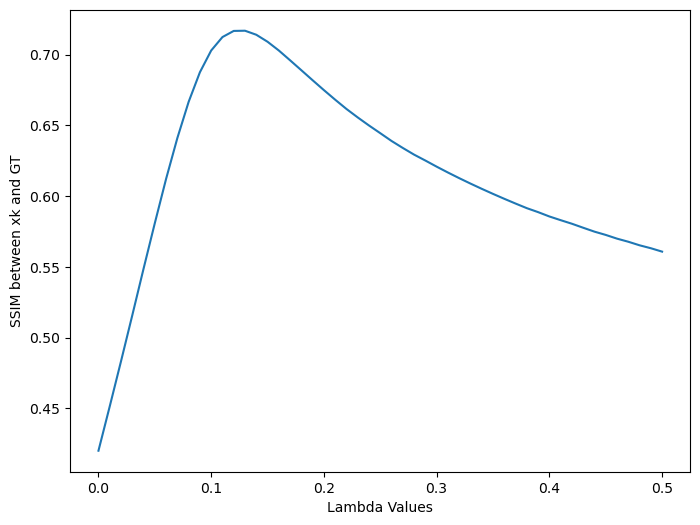

Iteration 0.0 / 50.0
I got stopped at iteration 1 because of SSIM


C:\Users\Claudio\AppData\Local\Temp\ipykernel_13532\2333140871.py:110: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(cost[k] - cost[k-1]) / cost[k] < 10 * stopping_threshold:


I got stopped at iteration 29 because of Cost function
I got stopped at iteration 56 because of Cost function
I got stopped at iteration 83 because of Cost function
I got stopped at iteration 111 because of Cost function
I got stopped at iteration 137 because of Cost function
I got stopped at iteration 163 because of Cost function
I got stopped at iteration 186 because of Cost function
I got stopped at iteration 207 because of Cost function
I got stopped at iteration 225 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 240 because of Cost function
I got stopped at iteration 249 because of SSIM
I got stopped at iteration 226 because of SSIM
I got stopped at iteration 206 because of SSIM
I got stopped at iteration 191 because of SSIM
I got stopped at iteration 179 because of SSIM
I got stopped at iteration 170 because of SSIM
I got stopped at iteration 163 because of SSIM
I got stopped at iteration 157 because of SSIM
I got stopped at iteration 153 because of SSI

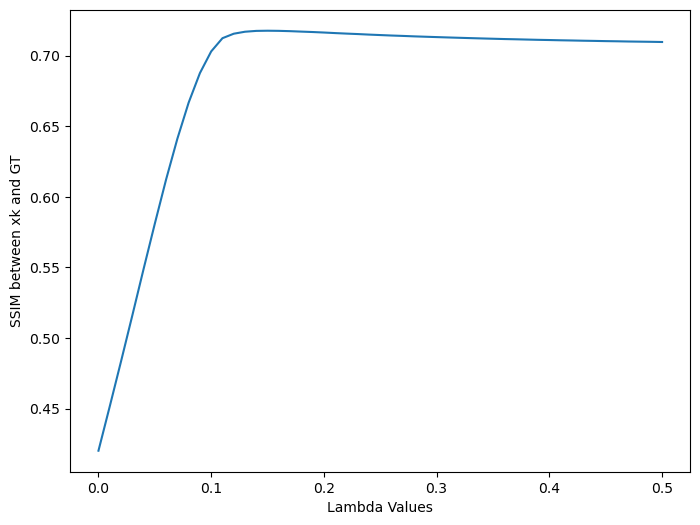

Iteration 0.0 / 50.0
I got stopped at iteration 2 because of Cost function
I got stopped at iteration 30 because of Cost function
I got stopped at iteration 59 because of Cost function
I got stopped at iteration 89 because of Cost function
I got stopped at iteration 119 because of Cost function
I got stopped at iteration 149 because of Cost function
I got stopped at iteration 179 because of Cost function
I got stopped at iteration 207 because of Cost function
I got stopped at iteration 232 because of Cost function
I got stopped at iteration 253 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 271 because of Cost function
I got stopped at iteration 284 because of Cost function
I got stopped at iteration 294 because of Cost function
I got stopped at iteration 301 because of Cost function
I got stopped at iteration 306 because of Cost function
I got stopped at iteration 309 because of Cost function
I got stopped at iteration 311 because of Cost function
I got stop

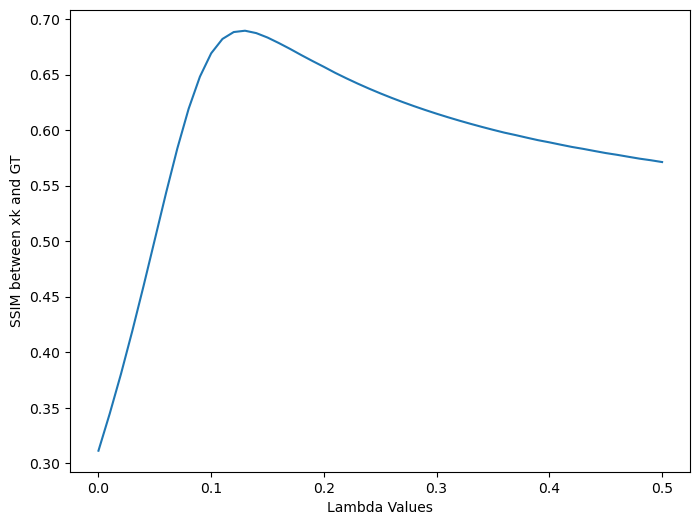

Iteration 0.0 / 50.0
I got stopped at iteration 1 because of SSIM
I got stopped at iteration 30 because of Cost function
I got stopped at iteration 59 because of Cost function
I got stopped at iteration 89 because of Cost function
I got stopped at iteration 119 because of Cost function
I got stopped at iteration 149 because of Cost function
I got stopped at iteration 179 because of Cost function
I got stopped at iteration 207 because of Cost function
I got stopped at iteration 232 because of Cost function
I got stopped at iteration 253 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 271 because of Cost function
I got stopped at iteration 283 because of SSIM
I got stopped at iteration 254 because of SSIM
I got stopped at iteration 229 because of SSIM
I got stopped at iteration 210 because of SSIM
I got stopped at iteration 196 because of SSIM
I got stopped at iteration 186 because of SSIM
I got stopped at iteration 178 because of SSIM
I got stopped at iteration

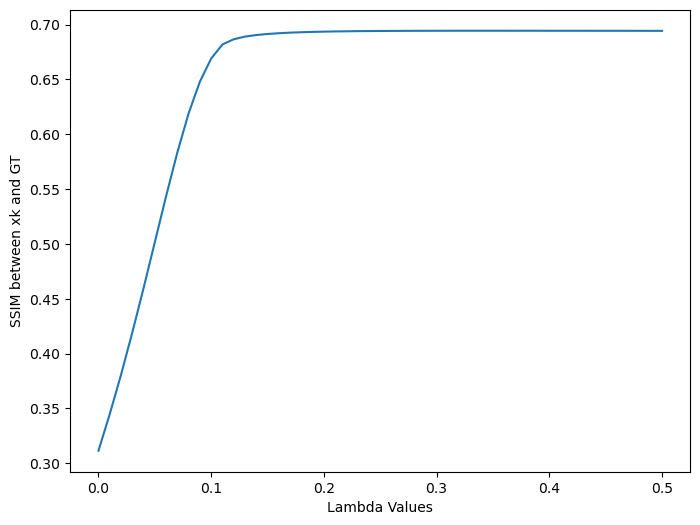

Iteration 0.0 / 50.0
I got stopped at iteration 2 because of Cost function
I got stopped at iteration 29 because of Cost function
I got stopped at iteration 57 because of Cost function
I got stopped at iteration 85 because of Cost function
I got stopped at iteration 113 because of Cost function
I got stopped at iteration 139 because of Cost function
I got stopped at iteration 164 because of Cost function
I got stopped at iteration 187 because of Cost function
I got stopped at iteration 206 because of Cost function
I got stopped at iteration 222 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 235 because of Cost function
I got stopped at iteration 244 because of Cost function
I got stopped at iteration 250 because of Cost function
I got stopped at iteration 255 because of Cost function
I got stopped at iteration 258 because of Cost function
I got stopped at iteration 261 because of Cost function
I got stopped at iteration 263 because of Cost function
I got stop

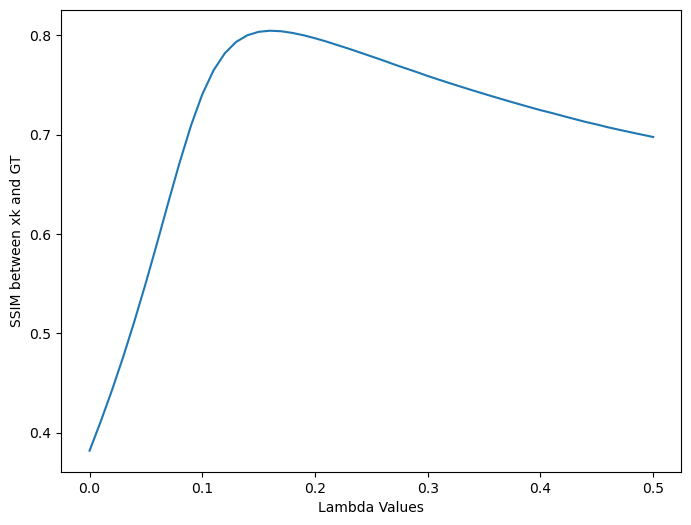

Iteration 0.0 / 50.0
I got stopped at iteration 1 because of SSIM
I got stopped at iteration 29 because of Cost function
I got stopped at iteration 57 because of Cost function
I got stopped at iteration 85 because of Cost function
I got stopped at iteration 113 because of Cost function
I got stopped at iteration 139 because of Cost function
I got stopped at iteration 164 because of Cost function
I got stopped at iteration 187 because of Cost function
I got stopped at iteration 206 because of Cost function
I got stopped at iteration 222 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 235 because of Cost function
I got stopped at iteration 244 because of Cost function
I got stopped at iteration 250 because of Cost function
I got stopped at iteration 255 because of Cost function
I got stopped at iteration 258 because of Cost function
I got stopped at iteration 249 because of SSIM
I got stopped at iteration 233 because of SSIM
I got stopped at iteration 221 becaus

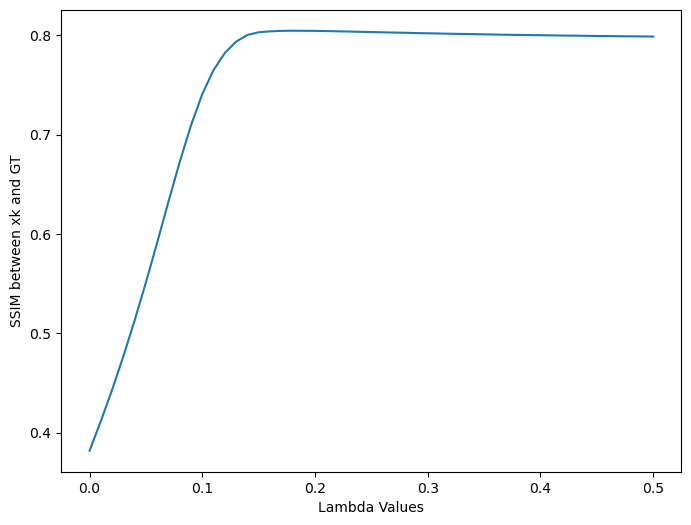

Iteration 0.0 / 50.0
I got stopped at iteration 2 because of Cost function
I got stopped at iteration 29 because of Cost function
I got stopped at iteration 58 because of Cost function
I got stopped at iteration 87 because of Cost function
I got stopped at iteration 117 because of Cost function
I got stopped at iteration 147 because of Cost function
I got stopped at iteration 176 because of Cost function
I got stopped at iteration 204 because of Cost function
I got stopped at iteration 230 because of Cost function
I got stopped at iteration 252 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 271 because of Cost function
I got stopped at iteration 285 because of Cost function
I got stopped at iteration 296 because of Cost function
I got stopped at iteration 303 because of Cost function
I got stopped at iteration 308 because of Cost function
I got stopped at iteration 311 because of Cost function
I got stopped at iteration 312 because of Cost function
I got stop

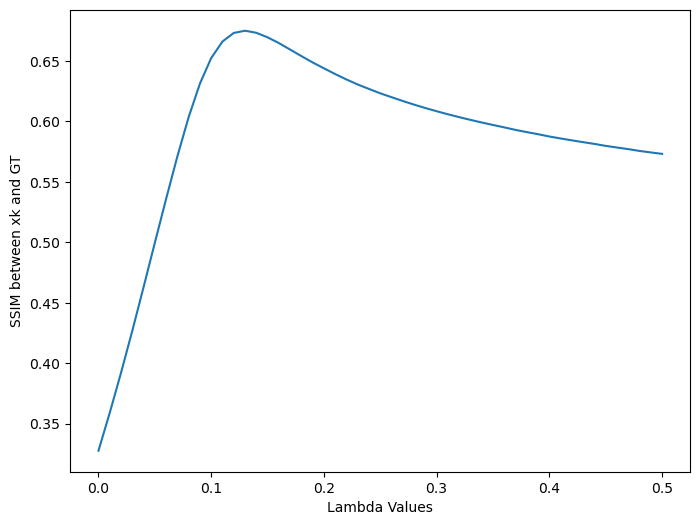

Iteration 0.0 / 50.0
I got stopped at iteration 1 because of SSIM
I got stopped at iteration 29 because of Cost function
I got stopped at iteration 58 because of Cost function
I got stopped at iteration 87 because of Cost function
I got stopped at iteration 117 because of Cost function
I got stopped at iteration 147 because of Cost function
I got stopped at iteration 176 because of Cost function
I got stopped at iteration 204 because of Cost function
I got stopped at iteration 230 because of Cost function
I got stopped at iteration 252 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 271 because of Cost function
I got stopped at iteration 272 because of SSIM
I got stopped at iteration 244 because of SSIM
I got stopped at iteration 220 because of SSIM
I got stopped at iteration 203 because of SSIM
I got stopped at iteration 189 because of SSIM
I got stopped at iteration 179 because of SSIM
I got stopped at iteration 171 because of SSIM
I got stopped at iteration

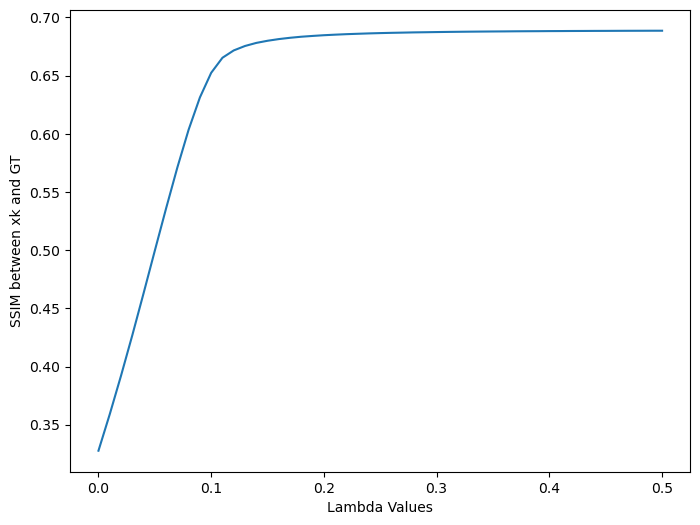

Iteration 0.0 / 50.0
I got stopped at iteration 2 because of Cost function
I got stopped at iteration 30 because of Cost function
I got stopped at iteration 60 because of Cost function
I got stopped at iteration 91 because of Cost function
I got stopped at iteration 123 because of Cost function
I got stopped at iteration 155 because of Cost function
I got stopped at iteration 187 because of Cost function
I got stopped at iteration 218 because of Cost function
I got stopped at iteration 245 because of Cost function
I got stopped at iteration 268 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 286 because of Cost function
I got stopped at iteration 297 because of Cost function
I got stopped at iteration 303 because of Cost function
I got stopped at iteration 304 because of Cost function
I got stopped at iteration 302 because of Cost function
I got stopped at iteration 299 because of Cost function
I got stopped at iteration 295 because of Cost function
I got stop

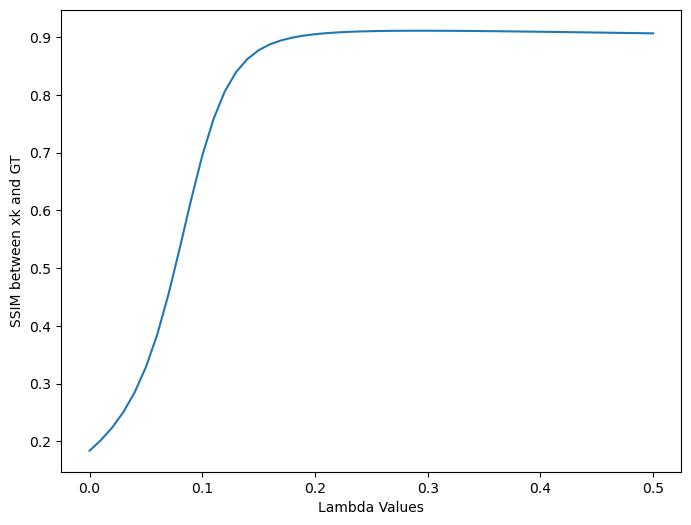

Iteration 0.0 / 50.0
I got stopped at iteration 1 because of SSIM
I got stopped at iteration 30 because of Cost function
I got stopped at iteration 60 because of Cost function
I got stopped at iteration 91 because of Cost function
I got stopped at iteration 123 because of Cost function
I got stopped at iteration 155 because of Cost function
I got stopped at iteration 187 because of Cost function
I got stopped at iteration 218 because of Cost function
I got stopped at iteration 245 because of Cost function
I got stopped at iteration 268 because of Cost function
Iteration 10.0 / 50.0
I got stopped at iteration 286 because of Cost function
I got stopped at iteration 297 because of Cost function
I got stopped at iteration 303 because of Cost function
I got stopped at iteration 304 because of Cost function
I got stopped at iteration 302 because of Cost function
I got stopped at iteration 299 because of Cost function
I got stopped at iteration 295 because of Cost function
I got stopped at it

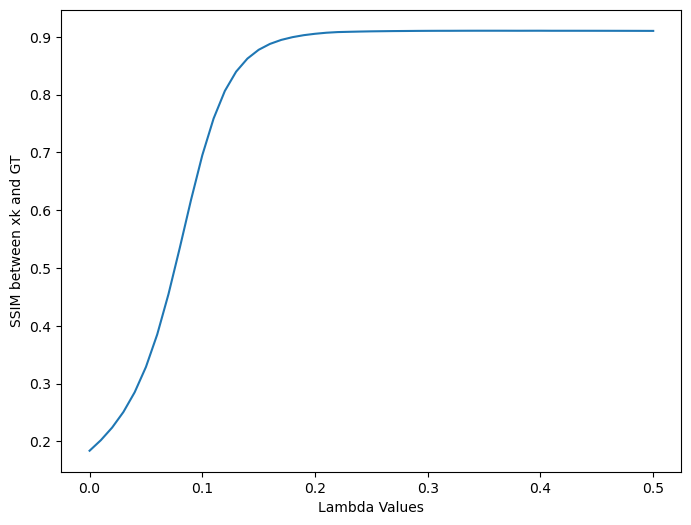

In [14]:
stopValue = 0.51
for j in range(0,5):
  filename = "ImagesOriginales/%s.jpg" %j
  img = np.array(plt.imread(filename)/255, dtype="float64")
  lmbda = np.arange(0,stopValue,0.01)
  runBruteScript(img,lmbda, stopValue, SSIMstop = False, early_stopping = True)
  runBruteScript(img,lmbda, stopValue,SSIMstop = True, early_stopping = True)

The last two graphs of brute force algorithm are about the image n.4 and have this weird "plateu" behaviour in both SSIM stop and cost function stop

In [73]:
def runGoldenSection(img,lmbda, early_stopping, SSIMstop, alpha, maxiter = 400, mode = 'gaussian'):
  y = generateNoise(img,mode = mode,seed = 43,clip = False,var = 0.02)
  s = {}
  start = time.time()
  for i in range(0,len(alpha)):
    print("--------")
    print(f"range examined: {np.arange(start = lmbda - 2 * alpha[i], stop = lmbda + 2 * alpha[i] + 10e-5, step = alpha[i])}")
    for lmbdak in np.arange(start = lmbda - 2 * alpha[i], stop = lmbda + 2 * alpha[i] + 10e-5, step = alpha[i]):
      lmbdak = round(lmbdak,3) # overcoming weird numerical cancellation
      xk = y
      if SSIMstop == True:
        xk, lmbda, cost, err, SSIMerr, xkSeq = SSIMGradientDescent(xk, lmbdak, maxiter, y, img, early_stopping, stopping_threshold = 10e-5)
      if SSIMstop == False:
        xk, lmbda, cost, err, SSIMerr, xkSeq, iter = GradientDescent(x0 = xk, lmbda = lmbdak, maxiter = maxiter, y = y, img = img, early_stopping=early_stopping, stopping_threshold = 10e-5)
      s[lmbdak] = SSIMerr[iter]
    lmbda = max(s.items(), key=operator.itemgetter(1))[0]
    print(s)
  end = time.time()
  print(f"computational time required {end - start} s and the optima lambda is {lmbda}")
  s = {key: s[key] for key in sorted(s)}
  keys = list(s.keys())
  values = list(s.values())
  
  plt.scatter(keys,values)
  plt.xlabel("Lambda values")
  plt.ylabel("SSIM between xk and GT")
  plt.show()




    
  
 

Given the fact that the graph of (lambda, SSIM) is concave, we can exploit some golden section algorithm to found the optimal lambda in a lower computational time. The reduction in time is often about 800 s to 300 s

The below graphs are in order: from image n.0 to image n.4

--------
range examined: [0.   0.15 0.3  0.45 0.6 ]
I got stopped at iteration 1 because of Sequence norm


C:\Users\Claudio\AppData\Local\Temp\ipykernel_9404\3848196698.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(cost[k] - cost[k-1]) / cost[k] < 10 * stopping_threshold:


I got stopped at iteration 277 because of Cost function
I got stopped at iteration 316 because of Cost function
I got stopped at iteration 342 because of Cost function
I got stopped at iteration 363 because of Cost function
{0.0: 0.42010521862029365, 0.15: 0.7091408343513517, 0.3: 0.6208687956417798, 0.45: 0.5726200682088224, 0.6: 0.541898113488893}
--------
range examined: [0.05 0.1  0.15 0.2  0.25]
I got stopped at iteration 137 because of Cost function
I got stopped at iteration 235 because of Sequence norm
I got stopped at iteration 277 because of Cost function
I got stopped at iteration 294 because of Cost function
I got stopped at iteration 306 because of Cost function
{0.0: 0.42010521862029365, 0.15: 0.7091408343513517, 0.3: 0.6208687956417798, 0.45: 0.5726200682088224, 0.6: 0.541898113488893, 0.05: 0.5809497662693377, 0.1: 0.7023627403971825, 0.2: 0.6749530085437483, 0.25: 0.6445139707965525}
--------
range examined: [0.12  0.135 0.15  0.165 0.18 ]
I got stopped at iteration 26

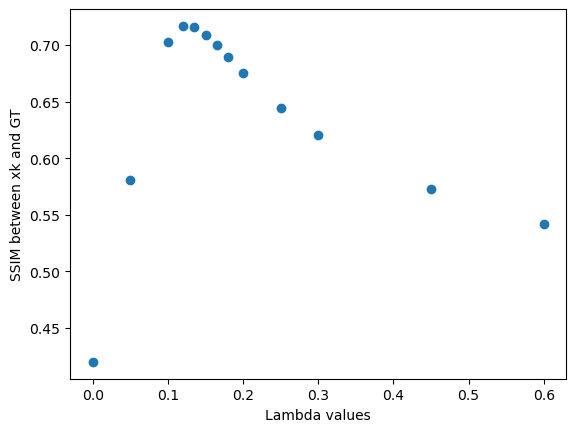

--------
range examined: [0.   0.15 0.3  0.45 0.6 ]
I got stopped at iteration 1 because of Sequence norm
I got stopped at iteration 308 because of Sequence norm
I got stopped at iteration 337 because of Cost function
I got stopped at iteration 364 because of Cost function
I got stopped at iteration 386 because of Cost function
{0.0: 0.31137865010762017, 0.15: 0.6833917944436643, 0.3: 0.6147233335716941, 0.45: 0.5793158824698726, 0.6: 0.5582472701008959}
--------
range examined: [0.05 0.1  0.15 0.2  0.25]
I got stopped at iteration 149 because of Cost function
I got stopped at iteration 251 because of Sequence norm
I got stopped at iteration 308 because of Sequence norm
I got stopped at iteration 316 because of Cost function
I got stopped at iteration 327 because of Cost function
{0.0: 0.31137865010762017, 0.15: 0.6833917944436643, 0.3: 0.6147233335716941, 0.45: 0.5793158824698726, 0.6: 0.5582472701008959, 0.05: 0.5015526906709629, 0.1: 0.6665326349753959, 0.2: 0.6569043346027498, 0.25

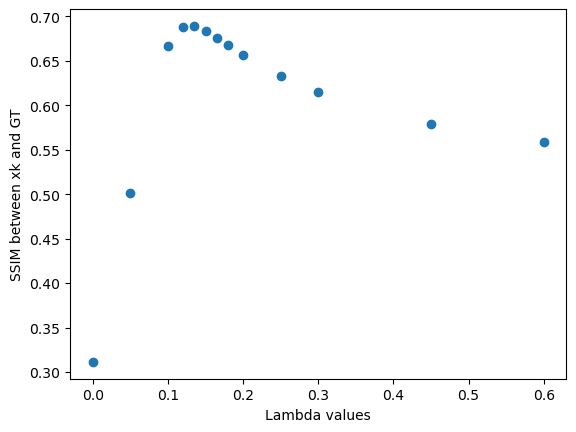

--------
range examined: [0.   0.15 0.3  0.45 0.6 ]
I got stopped at iteration 1 because of Sequence norm
I got stopped at iteration 261 because of Cost function
I got stopped at iteration 314 because of Cost function
I got stopped at iteration 372 because of Cost function
{0.0: 0.38181049337774564, 0.15: 0.8036062511462709, 0.3: 0.7591124093931909, 0.45: 0.7102843982213543, 0.6: 0.6815432324525775}
--------
range examined: [0.05 0.1  0.15 0.2  0.25]
I got stopped at iteration 139 because of Cost function
I got stopped at iteration 228 because of Sequence norm
I got stopped at iteration 261 because of Cost function
I got stopped at iteration 274 because of Cost function
I got stopped at iteration 292 because of Cost function
{0.0: 0.38181049337774564, 0.15: 0.8036062511462709, 0.3: 0.7591124093931909, 0.45: 0.7102843982213543, 0.6: 0.6815432324525775, 0.05: 0.5512479181612143, 0.1: 0.7384871263210636, 0.2: 0.7971219791253967, 0.25: 0.7788544417754222}
--------
range examined: [0.12  0.

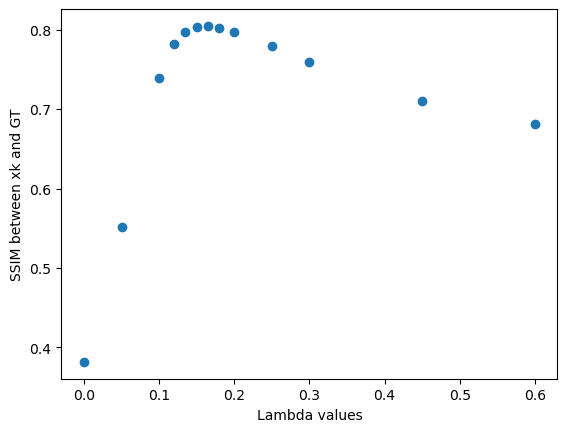

--------
range examined: [0.   0.15 0.3  0.45 0.6 ]
I got stopped at iteration 1 because of Sequence norm
I got stopped at iteration 311 because of Cost function
I got stopped at iteration 324 because of Cost function
I got stopped at iteration 342 because of Cost function
I got stopped at iteration 360 because of Cost function
{0.0: 0.327635572071125, 0.15: 0.6695977886875968, 0.3: 0.6084620517777399, 0.45: 0.5797977520788501, 0.6: 0.5622500627649605}
--------
range examined: [0.05 0.1  0.15 0.2  0.25]
I got stopped at iteration 147 because of Cost function
I got stopped at iteration 271 because of Cost function
I got stopped at iteration 311 because of Cost function
I got stopped at iteration 316 because of Cost function
I got stopped at iteration 320 because of Cost function
{0.0: 0.327635572071125, 0.15: 0.6695977886875968, 0.3: 0.6084620517777399, 0.45: 0.5797977520788501, 0.6: 0.5622500627649605, 0.05: 0.49958984397942496, 0.1: 0.6524298483800789, 0.2: 0.6439765600343285, 0.25: 0

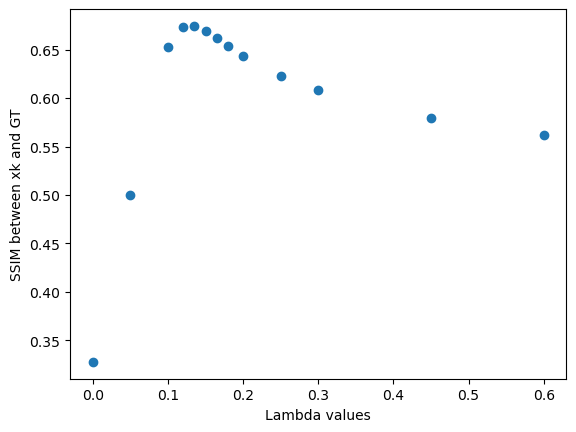

--------
range examined: [0.   0.15 0.3  0.45 0.6 ]
I got stopped at iteration 1 because of Sequence norm
I got stopped at iteration 245 because of Sequence norm
I got stopped at iteration 273 because of Cost function
I got stopped at iteration 283 because of Cost function
I got stopped at iteration 298 because of Cost function
{0.0: 0.1837681840971965, 0.15: 0.8535069512868168, 0.3: 0.9112044278340334, 0.45: 0.9080806264171798, 0.6: 0.9038406127363164}
--------
range examined: [0.2  0.25 0.3  0.35 0.4 ]
I got stopped at iteration 259 because of Sequence norm
I got stopped at iteration 274 because of Cost function
I got stopped at iteration 273 because of Cost function
I got stopped at iteration 275 because of Cost function
I got stopped at iteration 278 because of Cost function
{0.0: 0.1837681840971965, 0.15: 0.8535069512868168, 0.3: 0.9112044278340334, 0.45: 0.9080806264171798, 0.6: 0.9038406127363164, 0.2: 0.9015679932878934, 0.25: 0.9104696387863477, 0.35: 0.9105556344317965, 0.4: 

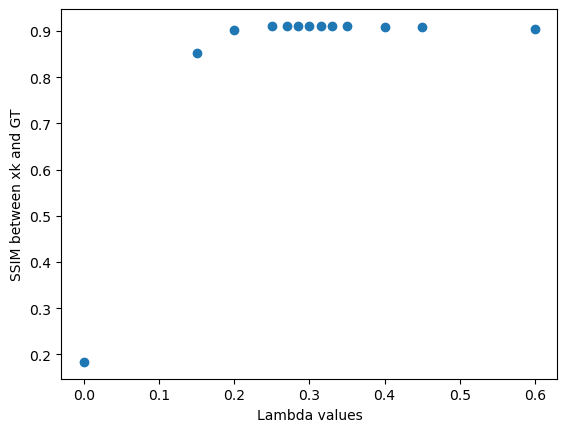

In [55]:

alpha = [0.15, 0.05, 0.015]

for j in range(0,5):
  filename = "ImagesOriginales/%s.jpg" %j
  img = np.array(plt.imread(filename)/255, dtype="float64")
  runGoldenSection(img = img,lmbda = 0.3, alpha = alpha, SSIMstop = False, early_stopping = True)
  

The optimal lambda for image 4 is 0.29 by brute force or 0.30 by golden section. But has this weird plateu behaviour. So I tried to use higher value of lambda to see if there is a another maximum  

--------
range examined: [0.4 0.7 1.  1.3 1.6]
I got stopped at iteration 278 because of Cost function
I got stopped at iteration 307 because of Cost function
I got stopped at iteration 327 because of Cost function
I got stopped at iteration 339 because of Cost function
I got stopped at iteration 348 because of Cost function
{0.4: 0.9094500384485733, 0.7: 0.9012727509273939, 1.0: 0.8953473815586802, 1.3: 0.8914883926447486, 1.6: 0.8886769310803447}
--------
range examined: [0.1  0.25 0.4  0.55 0.7 ]
I got stopped at iteration 224 because of Sequence norm
I got stopped at iteration 274 because of Cost function
I got stopped at iteration 278 because of Cost function
I got stopped at iteration 293 because of Cost function
I got stopped at iteration 307 because of Cost function
{0.4: 0.9094500384485733, 0.7: 0.9012727509273939, 1.0: 0.8953473815586802, 1.3: 0.8914883926447486, 1.6: 0.8886769310803447, 0.1: 0.65305890799783, 0.25: 0.9104696387863477, 0.55: 0.9052355951352106}
--------
range

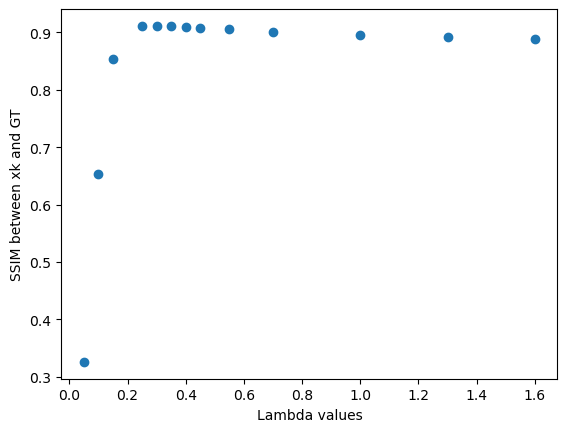

--------
range examined: [0.9 1.2 1.5 1.8 2.1]
I got stopped at iteration 321 because of Cost function
I got stopped at iteration 336 because of Cost function
I got stopped at iteration 345 because of Cost function
I got stopped at iteration 353 because of Cost function
I got stopped at iteration 358 because of Cost function
{0.9: 0.8970976128642494, 1.2: 0.8925552667208211, 1.5: 0.8895604460879175, 1.8: 0.8871682654362294, 2.1: 0.8854861160284686}
--------
range examined: [0.6  0.75 0.9  1.05 1.2 ]
I got stopped at iteration 298 because of Cost function
I got stopped at iteration 311 because of Cost function
I got stopped at iteration 321 because of Cost function
I got stopped at iteration 329 because of Cost function
I got stopped at iteration 336 because of Cost function
{0.9: 0.8970976128642494, 1.2: 0.8925552667208211, 1.5: 0.8895604460879175, 1.8: 0.8871682654362294, 2.1: 0.8854861160284686, 0.6: 0.9038406127363164, 0.75: 0.9001090210724442, 1.05: 0.8946405200905526}
--------
ran

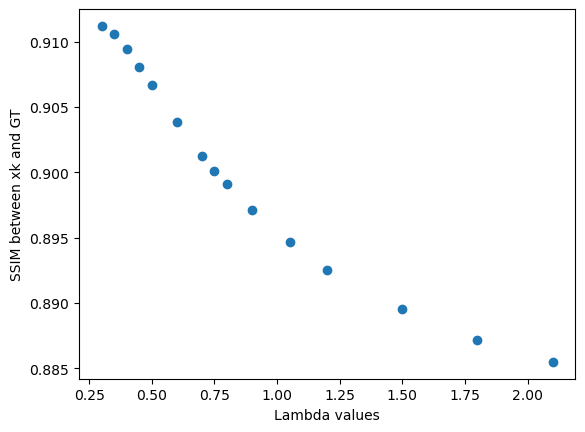

--------
range examined: [1.4 1.7 2.  2.3 2.6]
I got stopped at iteration 342 because of Cost function
I got stopped at iteration 350 because of Cost function
I got stopped at iteration 357 because of Cost function
I got stopped at iteration 361 because of Cost function
I got stopped at iteration 366 because of Cost function
{1.4: 0.890494438809912, 1.7: 0.8879705942629912, 2.0: 0.8859285416446232, 2.3: 0.8845316975662159, 2.6: 0.8831616297332026}
--------
range examined: [1.1  1.25 1.4  1.55 1.7 ]
I got stopped at iteration 332 because of Cost function
I got stopped at iteration 337 because of Cost function
I got stopped at iteration 342 because of Cost function
I got stopped at iteration 347 because of Cost function
I got stopped at iteration 350 because of Cost function
{1.4: 0.890494438809912, 1.7: 0.8879705942629912, 2.0: 0.8859285416446232, 2.3: 0.8845316975662159, 2.6: 0.8831616297332026, 1.1: 0.8938373853087326, 1.25: 0.8920756432519024, 1.55: 0.8890466983935493}
--------
range

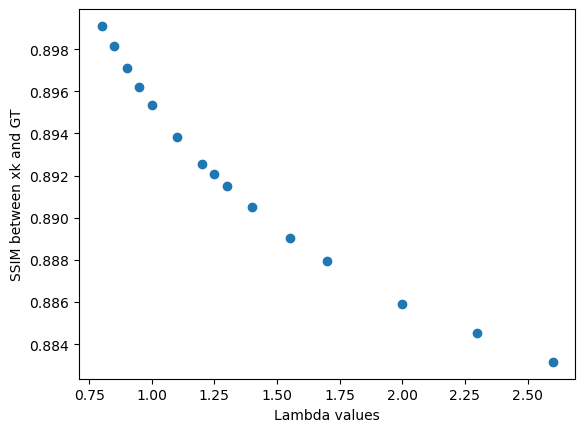

In [65]:
alpha = [0.3, 0.15, 0.1,0.05]
for lmbda in [1,1.5,2]:
  for j in range(4,5):
    filename = "ImagesOriginales/%s.jpg" %j
    img = np.array(plt.imread(filename)/255, dtype="float64")
    runGoldenSection(img,lmbda = lmbda, alpha = alpha, SSIMstop = False, early_stopping = True)

This last cell is a random testing with the image 0, which optimal value is 0.13, with value of Lambda high. We can see the usual trend, where it reach a peak near lower value of lambda. It means that there is not a double descent phenomena

--------
range examined: [1. 3. 5. 7. 9.]
I got stopped at iteration 397 because of Cost function
{1.0: 0.4994596325124412, 3.0: 0.46777633525504303, 5.0: 0.4614376955588846, 7.0: 0.4586951449269783, 9.0: 0.4571639423434065}
--------
range examined: [-1.  0.  1.  2.  3.]
I got stopped at iteration 0 because of Cost function


C:\Users\Claudio\AppData\Local\Temp\ipykernel_9404\3848196698.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(cost[k] - cost[k-1]) / cost[k] < 10 * stopping_threshold:


I got stopped at iteration 1 because of Sequence norm
I got stopped at iteration 397 because of Cost function
{1.0: 0.4994596325124412, 3.0: 0.46777633525504303, 5.0: 0.4614376955588846, 7.0: 0.4586951449269783, 9.0: 0.4571639423434065, -1.0: 0.4231787507667761, 0.0: 0.42010521862029365, 2.0: 0.47560592657374007}
--------
range examined: [0.  0.5 1.  1.5 2. ]
I got stopped at iteration 1 because of Sequence norm
I got stopped at iteration 350 because of Cost function
I got stopped at iteration 397 because of Cost function
{1.0: 0.4994596325124412, 3.0: 0.46777633525504303, 5.0: 0.4614376955588846, 7.0: 0.4586951449269783, 9.0: 0.4571639423434065, -1.0: 0.4231787507667761, 0.0: 0.42010521862029365, 2.0: 0.47560592657374007, 0.5: 0.5608074895342805, 1.5: 0.48336870838414625}
computational time required 324.1607081890106 s and the optima lambda is 0.5


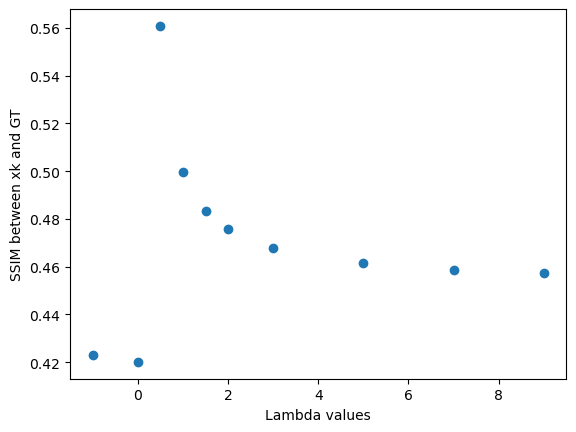

In [78]:

alpha = [2, 1, 0.5]

for j in range(0,1):
  filename = "ImagesOriginales/%s.jpg" %j
  img = np.array(plt.imread(filename)/255, dtype="float64")
  runGoldenSection(img = img,lmbda = 5, alpha = alpha, SSIMstop = False, early_stopping = True)